In [1]:
# !pip install oolearning --upgrade

In [2]:
import math
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, Imputer, MinMaxScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

import oolearning as oo
from helpers import DataFrameSelector, CustomLogTransform, ChooserTransform, CombineAgeHoursTransform, CombineCapitalGainLossTransform

pd.set_option('display.width', 500)
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
width = 10
plt.rcParams['figure.figsize'] = [width, width/1.333]

In [3]:
os.getcwd()

'/home/shane/repos/udacity/data_scientist_nanodegree/projects/p1_charityml/custom v2'

In [4]:
csv_file = '../census.csv'
target_variable = 'income'

explore = oo.ExploreClassificationDataset.from_csv(csv_file_path=csv_file,
                                                   target_variable=target_variable)
negative_class = '<=50K'
positive_class = '>50K'

explore.dataset.head(20)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K


In [5]:
explore.numeric_summary()

,count,nulls,perc_nulls,num_zeros,perc_zeros,mean,st_dev,coef of var,skewness,kurtosis,min,10%,25%,50%,75%,90%,max
age,45222,0,0.0,0,0.000,38.548,13.218,0.343,0.533,-0.156,17.0,22.0,28.0,37.0,47.0,57.0,90.0
education-num,45222,0,0.0,0,0.000,10.118,2.553,0.252,-0.311,0.635,1.0,7.0,9.0,10.0,13.0,13.0,16.0
capital-gain,45222,0,0.0,41432,0.916,1101.430,7506.430,6.815,11.789,150.151,0.0,0.0,0.0,0.0,0.0,0.0,99999.0
capital-loss,45222,0,0.0,43082,0.953,88.595,404.956,4.571,4.516,19.364,0.0,0.0,0.0,0.0,0.0,0.0,4356.0
hours-per-week,45222,0,0.0,0,0.000,40.938,12.008,0.293,0.341,3.201,1.0,25.0,40.0,40.0,45.0,55.0,99.0


In [6]:
explore.categoric_summary()

,count,nulls,perc_nulls,top,unique,perc_unique
workclass,45222,0,0.0,Private,7,0.000
education_level,45222,0,0.0,HS-grad,16,0.000
marital-status,45222,0,0.0,Married-civ-spouse,7,0.000
occupation,45222,0,0.0,Craft-repair,14,0.000
relationship,45222,0,0.0,Husband,6,0.000
race,45222,0,0.0,White,5,0.000
sex,45222,0,0.0,Male,2,0.000
native-country,45222,0,0.0,United-States,41,0.001
income,45222,0,0.0,<=50K,2,0.000


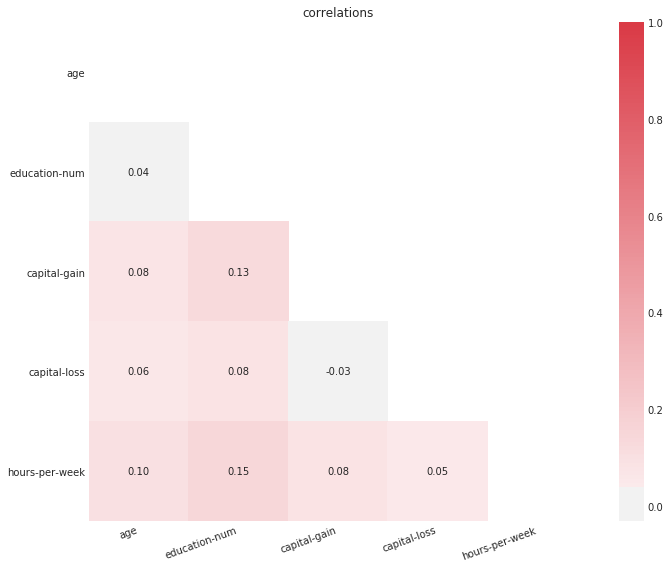

In [7]:
explore.plot_correlation_heatmap()

In [8]:
country_values = explore.dataset['native-country'].value_counts()
country_values = pd.DataFrame(country_values)
country_values['lookup'] = country_values.index.values
country_values.replace({'lookup': 
                        {'South': 'Korea, Rep.', 
                         'Hong':'Hong Kong SAR, China',
                         'England': 'United Kingdom',
                         'Columbia': 'Colombia',
                         'Iran': 'Iran, Islamic Rep.',
                         #'Taiwan': 'unknown',
                         'Trinadad&Tobago': 'Trinidad and Tobago',
                         'Holand-Netherlands': 'Netherlands',
                         'Scotland': 'United Kingdom',
                        }
                                }, inplace=True)
#country_values

In [9]:
gdp_per_capita = pd.read_csv('gdp_per_capita.csv')

In [10]:
country_values['gdp_per_capita'] = [gdp_per_capita[gdp_per_capita['Country Name'] ==  x.replace('-', ' ')].GDP_PER_CAPITA.iloc[0] if x.replace('-', ' ') in gdp_per_capita['Country Name'].values else np.nan for x in country_values['lookup'].values]

In [11]:
yugoslavia = ['Serbia', 'Montenegro', 'Slovenia', 'Croatia', 'Macedonia, FYR', 'Kosovo']
gdps_per_capita_yugo = [gdp_per_capita[gdp_per_capita['Country Name'] == x].GDP_PER_CAPITA.iloc[0] for x in yugoslavia]
mean_gdp_per_capita_yugo = np.mean(gdps_per_capita_yugo)
mean_gdp_per_capita_yugo

19995.586656386367

In [12]:
country_values.loc[country_values['lookup'] == 'Yugoslavia', 'gdp_per_capita'] = mean_gdp_per_capita_yugo

In [13]:
country_values.loc[country_values['lookup'] == 'Taiwan', 'gdp_per_capita'] = 8342.804479  # Philippines

In [14]:
country_values.gdp_per_capita.fillna(country_values.gdp_per_capita.quantile(q=.25), inplace=True)
assert not country_values.gdp_per_capita.isna().any()
country_values

,native-country,lookup,gdp_per_capita
United-States,41292,United-States,59531.661964
Mexico,903,Mexico,18258.096211
Philippines,283,Philippines,8342.804479
Germany,193,Germany,50638.890964
Puerto-Rico,175,Puerto-Rico,8342.804479
Canada,163,Canada,46704.894722
El-Salvador,147,El-Salvador,8006.059219
India,147,India,7055.554830
Cuba,133,Cuba,8342.804479
England,119,United Kingdom,43268.783556


In [15]:
explore.dataset['gdp_per_capita']=[country_values[country_values.index == x].gdp_per_capita.iloc[0] for x in explore.dataset['native-country']]

In [16]:
explore.dataset.head(10)

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,gdp_per_capita
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,59531.661964
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,59531.661964
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,59531.661964
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,59531.661964
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,8342.804479
5,37,Private,Masters,14.0,Married-civ-spouse,Exec-managerial,Wife,White,Female,0.0,0.0,40.0,United-States,<=50K,59531.661964
6,49,Private,9th,5.0,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0.0,0.0,16.0,Jamaica,<=50K,8995.350211
7,52,Self-emp-not-inc,HS-grad,9.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,45.0,United-States,>50K,59531.661964
8,31,Private,Masters,14.0,Never-married,Prof-specialty,Not-in-family,White,Female,14084.0,0.0,50.0,United-States,>50K,59531.661964
9,42,Private,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178.0,0.0,40.0,United-States,>50K,59531.661964


In [17]:
# NOTE: since I will be cross-validating transformations e.g. GridSearchCV, it typically won't work to
# one-hot-encode during cross-validation because the holdout fold will tend to have categoric values that
# weren't found in the training folds, and therefore will break during transformation because it will encode
# a value (i.e. add a column) that didn't exist in the training folds.
# So, for this, we need to fit ALL data. Then, below if we have new data e.g. Kaggle, we have to apply
# the same pipeline (i.e.  cat_encoding_pipeline.transform()
# TODO: this breaks though if there are any categorical features with missing values in the final test/Kaggle set
one_hot_transformer = oo.DummyEncodeTransformer(encoding=oo.CategoricalEncoding.ONE_HOT)
transformed_data = one_hot_transformer.fit_transform(explore.dataset.drop(columns=[target_variable] + ['native-country']))
transformed_data[target_variable] = explore.dataset[target_variable]

In [18]:
transformed_data.head(10)

,age,education-num,capital-gain,capital-loss,hours-per-week,gdp_per_capita,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_level_10th,education_level_11th,education_level_12th,education_level_1st-4th,education_level_5th-6th,education_level_7th-8th,education_level_9th,education_level_Assoc-acdm,education_level_Assoc-voc,education_level_Bachelors,education_level_Doctorate,education_level_HS-grad,education_level_Masters,education_level_Preschool,education_level_Prof-school,education_level_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,income
0,39,13.0,2174.0,0.0,40.0,59531.661964,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,<=50K
1,50,13.0,0.0,0.0,13.0,59531.661964,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,<=50K
2,38,9.0,0.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,<=50K
3,53,7.0,0.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,<=50K
4,28,13.0,0.0,0.0,40.0,8342.804479,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,<=50K
5,37,14.0,0.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,<=50K
6,49,5.0,0.0,0.0,16.0,8995.350211,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,<=50K
7,52,9.0,0.0,0.0,45.0,59531.661964,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,>50K
8,31,14.0,14084.0,0.0,50.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,>50K
9,42,13.0,5178.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,>50K


In [19]:
assert transformed_data.isna().sum().sum() == 0

# Transformations & Transformation Tuning Parameters

define the transformations we want to do, some transformations will have parameters (e.g. base of log tranform (or no transform), type of scaling, whether or not to add column combinations (e.g. age * hours-per-week)

Below is the pipeline for captail-gain/lost. 

We want to tune whether or not we should log transform. We need to do this after imputing but before scaling, so it needs to be it's own pipeline.

In [20]:
cap_gain_loss_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['capital-gain', 'capital-loss'])),
        #('imputer', Imputer()),
        # tune Log trasformation base (or no transformation)
        ('custom_transform', CustomLogTransform(base=math.e)),
        # tune "net gain" (have to do it after log transform)
        ('custom_cap_gain_minus_loss', CombineCapitalGainLossTransform(combine=True)),
        # tune MinMax vs StandardScaler
        ('custom_scaler', ChooserTransform(base_transformer=StandardScaler())),
    ])

Below is the pipeline for the rest of numeric features:

In [21]:
num_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribute_names=['age', 'education-num', 'hours-per-week', 'gdp_per_capita'])),
        #('imputer', Imputer()),
        # tune age * hours-per-week; update: tuned -chose not to include
        ('combine_agehours', CombineAgeHoursTransform()),
        # tune MinMax vs StandardScaler; update: tuned - chose MinMax
        ('custom_scaler', ChooserTransform(base_transformer=StandardScaler())),
    ])

Pipeline that simply gets the categorical/encoded columns from the previous transformation (which used `oo-learning`)

In [22]:
append_categoricals = Pipeline([
        ('append_cats', DataFrameSelector(attribute_names=one_hot_transformer.encoded_columns))  # already encoded
    ])

Below is the pipeline for combining all of the other pipelines

In [23]:
# combine pipelines
transformations_pipeline = FeatureUnion(transformer_list=[
        ("cap_gain_loss_pipeline", cap_gain_loss_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", append_categoricals),
    ])

In [24]:
test_transformations = transformations_pipeline.fit_transform(transformed_data)

In [25]:
pd.DataFrame(test_transformations).head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,2.815336,-0.222752,2.412200,0.034201,1.128753,-0.078120,-0.046799,0.284592,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.300328,-0.222752,-0.127317,0.866417,1.128753,-2.326738,-1.289722,0.284592,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,-0.300328,-0.222752,-0.127317,-0.041455,-0.438122,-0.078120,-0.101433,0.284592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,-0.300328,-0.222752,-0.127317,1.093385,-1.221559,-0.078120,0.718077,0.284592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.300328,-0.222752,-0.127317,-0.798015,1.128753,-0.078120,-0.647773,-4.086648,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5,-0.300328,-0.222752,-0.127317,-0.117111,1.520471,-0.078120,-0.156067,0.284592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6,-0.300328,-0.222752,-0.127317,0.790761,-2.004996,-2.076892,-1.106698,-4.030924,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7,-0.300328,-0.222752,-0.127317,1.017729,-0.438122,0.338291,1.018564,0.284592,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
8,3.572717,-0.222752,3.029527,-0.571047,1.520471,0.754701,-0.060457,0.284592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
9,3.167082,-0.222752,2.698902,0.261169,1.128753,-0.078120,0.117103,0.284592,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [26]:
transformed_data.head(10)

,age,education-num,capital-gain,capital-loss,hours-per-week,gdp_per_capita,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,education_level_10th,education_level_11th,education_level_12th,education_level_1st-4th,education_level_5th-6th,education_level_7th-8th,education_level_9th,education_level_Assoc-acdm,education_level_Assoc-voc,education_level_Bachelors,education_level_Doctorate,education_level_HS-grad,education_level_Masters,education_level_Preschool,education_level_Prof-school,education_level_Some-college,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed,occupation_Adm-clerical,occupation_Armed-Forces,occupation_Craft-repair,occupation_Exec-managerial,occupation_Farming-fishing,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other-service,occupation_Priv-house-serv,occupation_Prof-specialty,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,income
0,39,13.0,2174.0,0.0,40.0,59531.661964,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,<=50K
1,50,13.0,0.0,0.0,13.0,59531.661964,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,<=50K
2,38,9.0,0.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,<=50K
3,53,7.0,0.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,<=50K
4,28,13.0,0.0,0.0,40.0,8342.804479,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,<=50K
5,37,14.0,0.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,<=50K
6,49,5.0,0.0,0.0,16.0,8995.350211,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,<=50K
7,52,9.0,0.0,0.0,45.0,59531.661964,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,>50K
8,31,14.0,14084.0,0.0,50.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,>50K
9,42,13.0,5178.0,0.0,40.0,59531.661964,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,>50K


Choose the transformations to tune, below:

In [27]:
from scipy.stats import randint, uniform, expon

(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([0.2036593 , 0.28227106, 0.36088283, 0.4394946 , 0.51810636,
        0.59671813, 0.6753299 , 0.75394166, 0.83255343, 0.9111652 ,
        0.98977696]),
 <a list of 10 Patch objects>)

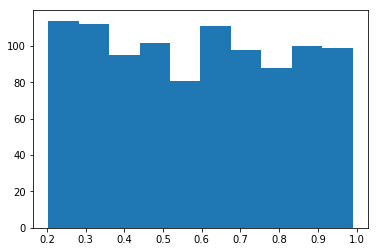

In [28]:
np.random.seed(42)
s = uniform(.2, .79).rvs(size=1000)
plt.hist(s)

In [29]:
min(s)

0.20365929817363626

In [30]:
max(s)

0.9897769618960433

(array([114., 112.,  95., 102.,  81., 111.,  98.,  88., 100.,  99.]),
 array([0.04632023, 1.04140588, 2.03649153, 3.03157718, 4.02666283,
        5.02174848, 6.01683413, 7.01191978, 8.00700543, 9.00209108,
        9.99717673]),
 <a list of 10 Patch objects>)

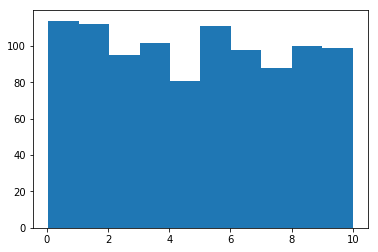

In [31]:
np.random.seed(42)
s = uniform(0, 10).rvs(size=1000)
plt.hist(s)

In [32]:
min(s)

0.04632023004602859

In [33]:
max(s)

9.997176732861305

(array([111., 105., 104.,  95.,  84., 112.,  98.,  89.,  83., 119.]),
 array([ 2. , 11.7, 21.4, 31.1, 40.8, 50.5, 60.2, 69.9, 79.6, 89.3, 99. ]),
 <a list of 10 Patch objects>)

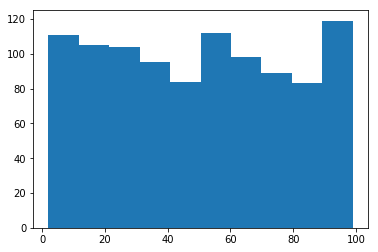

In [34]:
np.random.seed(42)
s = randint(2, 100).rvs(size=1000)
plt.hist(s)

In [35]:
min(s)

2

In [36]:
max(s)

99

In [37]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
model = ExtraTreesClassifier(random_state=42)

In [38]:
model_param_dict = {
    'model__max_features': uniform(.2, .8),
    'model__n_estimators': randint(100, 4000),
    'model__max_depth': randint(2, 100),
    'model__min_samples_split': uniform(0.001, 0.98),
    'model__min_samples_leaf': uniform(0.001, 0.49),
    'model__min_weight_fraction_leaf': uniform(0, 0.5),
}

In [39]:
full_pipeline = Pipeline([
    ('preparation', transformations_pipeline),
    #('pca_chooser', ChooserTransform()),
    #('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('model', model)
])

Tuning strategy according to https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [40]:
# actual hyper-parameters/options to tune for transformations.
transformation_parameters = {
         #'preparation__num_pipeline__imputer__strategy': ['mean', 'median', 'most_frequent'],  # tune strategy
         #'pca_chooser__base_transformer': [PCA(n_components=0.95, random_state=42), None],  # PCA vs not
         'preparation__cap_gain_loss_pipeline__custom_transform__base': [None, math.e],  # Log transform (base e) or not
         'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': [True, False],
#         'preparation__cap_gain_loss_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],
         'preparation__num_pipeline__combine_agehours__combine': [True, False],
 #        'preparation__num_pipeline__custom_scaler__base_transformer': [MinMaxScaler(), StandardScaler()],


    }

In [41]:
# def binary_roc_auc(y_true, y_score):
#     return roc_auc_score(y_true=y_true,
#                          # binary makes it so it converts the "scores" to predictions
#                          y_score=[1 if x > 0.5 else 0 for x in y_score])

scorer = make_scorer(roc_auc_score, greater_is_better=True)

In [42]:
y =  transformed_data[target_variable].apply(lambda x: 1 if x == positive_class else 0)

In [43]:
transformed_data[target_variable].values[0:10]

array(['<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K',
       '>50K', '>50K', '>50K'], dtype=object)

In [44]:
y[0:10]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    1
8    1
9    1
Name: income, dtype: int64

In [45]:
param_grid = {**transformation_parameters, **model_param_dict}
param_grid

{'preparation__cap_gain_loss_pipeline__custom_transform__base': [None,
  2.718281828459045],
 'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': [True,
  False],
 'preparation__num_pipeline__combine_agehours__combine': [True, False],
 'model__max_features': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbdc687e4e0>,
 'model__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbdc687e438>,
 'model__max_depth': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbdc687e160>,
 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbdc687e2e8>,
 'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbdc1e5ec50>,
 'model__min_weight_fraction_leaf': <scipy.stats._distn_infrastructure.rv_frozen at 0x7fbdc1e5e7b8>}

In [46]:
print('Starting....')
time_start = time.time()
from sklearn.model_selection import RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=full_pipeline,
                                 param_distributions=param_grid,
                                 n_iter=500,
                                 cv=RepeatedKFold(n_splits=5, n_repeats=1),
                                 scoring=scorer,
                                 return_train_score=True,
                                 n_jobs=-1,
                                 verbose=2)
grid_search.fit(transformed_data.drop(columns=target_variable), y)
time_end = time.time()

Starting....
Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] model__max_depth=96, model__max_features=0.2445227914855803, model__min_samples_leaf=0.413733877296109, model__min_samples_split=0.05160276831702258, model__min_weight_fraction_leaf=0.009121240714180523, model__n_estimators=328, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV] model__max_depth=96, model__max_features=0.2445227914855803, model__min_samples_leaf=0.413733877296109, model__min_samples_split=0.05160276831702258, model__min_weight_fraction_leaf=0.009121240714180523, model__n_estimators=328, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV] model__max_dep

[CV] model__max_depth=27, model__max_features=0.45894338912339494, model__min_samples_leaf=0.20946385492204422, model__min_samples_split=0.4984581711107659, model__min_weight_fraction_leaf=0.12120486620754012, model__n_estimators=658, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=96, model__max_features=0.2445227914855803, model__min_samples_leaf=0.413733877296109, model__min_samples_split=0.05160276831702258, model__min_weight_fraction_leaf=0.009121240714180523, model__n_estimators=328, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=   6.3s
[CV] model__max_depth=27, model__max_features=0.45894338912339494, model__min_sa

[CV] model__max_depth=65, model__max_features=0.26983214367174035, model__min_samples_leaf=0.24899093861608004, model__min_samples_split=0.9143740554117954, model__min_weight_fraction_leaf=0.16032109607975714, model__n_estimators=2406, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=52, model__max_features=0.856689178522682, model__min_samples_leaf=0.3530440627099113, model__min_samples_split=0.5253359974040123, model__min_weight_fraction_leaf=0.238309742063206, model__n_estimators=2320, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  44.0s
[CV] model__max_depth=11, model__max_features=0.6388824943505226, model__min_samples_leaf=0.26

[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   58.8s


[CV]  model__max_depth=27, model__max_features=0.45894338912339494, model__min_samples_leaf=0.20946385492204422, model__min_samples_split=0.4984581711107659, model__min_weight_fraction_leaf=0.12120486620754012, model__n_estimators=658, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  36.6s
[CV] model__max_depth=11, model__max_features=0.6388824943505226, model__min_samples_leaf=0.26997177014559887, model__min_samples_split=0.1986958530836311, model__min_weight_fraction_leaf=0.34228577393991666, model__n_estimators=1719, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=27, model__max_features=0.45894338912339494, model__min_samples_leaf=0

[CV] model__max_depth=63, model__max_features=0.7967796204389745, model__min_samples_leaf=0.2011739635385993, model__min_samples_split=0.9152793057579556, model__min_weight_fraction_leaf=0.4954647382286953, model__n_estimators=2735, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=11, model__max_features=0.6388824943505226, model__min_samples_leaf=0.26997177014559887, model__min_samples_split=0.1986958530836311, model__min_weight_fraction_leaf=0.34228577393991666, model__n_estimators=1719, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.7min
[CV] model__max_depth=63, model__max_features=0.7967796204389745, model__min_samples_leaf=0.2011739635385993,

[CV]  model__max_depth=41, model__max_features=0.7772772406010218, model__min_samples_leaf=0.024566375542402968, model__min_samples_split=0.7668841921163866, model__min_weight_fraction_leaf=0.41397044358874596, model__n_estimators=1352, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  31.8s
[CV] model__max_depth=36, model__max_features=0.3314126383447944, model__min_samples_leaf=0.40014161291337724, model__min_samples_split=0.6528932762822761, model__min_weight_fraction_leaf=0.26153271238455966, model__n_estimators=231, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=36, model__max_features=0.3314126383447944, model__min_samples_leaf=

[CV] model__max_depth=64, model__max_features=0.6021763120739834, model__min_samples_leaf=0.11478422062194048, model__min_samples_split=0.8825830818090771, model__min_weight_fraction_leaf=0.1919456106866057, model__n_estimators=2097, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=74, model__max_features=0.8081822879117493, model__min_samples_leaf=0.2928629828978437, model__min_samples_split=0.46314466477915517, model__min_weight_fraction_leaf=0.20592045707363427, model__n_estimators=3777, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.9min
[CV] model__max_depth=64, model__max_features=0.6021763120739834, model__min_samples_leaf=0.11

[CV] model__max_depth=30, model__max_features=0.5963389011231726, model__min_samples_leaf=0.36431584645813225, model__min_samples_split=0.562687832272241, model__min_weight_fraction_leaf=0.49884630796192164, model__n_estimators=3612, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=90, model__max_features=0.7463856507337059, model__min_samples_leaf=0.22245481463652922, model__min_samples_split=0.7005068057582194, model__min_weight_fraction_leaf=0.44983372264608656, model__n_estimators=3808, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.1min
[CV] model__max_depth=30, model__max_features=0.5963389011231726, model__min_samples_leaf=0.364315846458132

[CV]  model__max_depth=28, model__max_features=0.7951570340581415, model__min_samples_leaf=0.0174308930205319, model__min_samples_split=0.5594918911738902, model__min_weight_fraction_leaf=0.38122934287034527, model__n_estimators=1758, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  37.3s
[CV] model__max_depth=39, model__max_features=0.6291850811876758, model__min_samples_leaf=0.1866225671228887, model__min_samples_split=0.4488602148960448, model__min_weight_fraction_leaf=0.30197893603625625, model__n_estimators=2162, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=52, model__max_features=0.6342794484907271, model__min_samples_leaf=0.2

[CV]  model__max_depth=30, model__max_features=0.5963389011231726, model__min_samples_leaf=0.36431584645813225, model__min_samples_split=0.562687832272241, model__min_weight_fraction_leaf=0.49884630796192164, model__n_estimators=3612, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.9min
[CV] model__max_depth=44, model__max_features=0.6792234918218611, model__min_samples_leaf=0.4061314256264484, model__min_samples_split=0.9408932986727472, model__min_weight_fraction_leaf=0.1712621285892717, model__n_estimators=3305, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=30, model__max_features=0.5963389011231726, model__min_samples_leaf=0.3643158464581322

[CV] model__max_depth=91, model__max_features=0.9578266716894523, model__min_samples_leaf=0.07614218752687929, model__min_samples_split=0.5755052353764613, model__min_weight_fraction_leaf=0.252944339442233, model__n_estimators=1084, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=39, model__max_features=0.6291850811876758, model__min_samples_leaf=0.1866225671228887, model__min_samples_split=0.4488602148960448, model__min_weight_fraction_leaf=0.30197893603625625, model__n_estimators=2162, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.2min
[CV] model__max_depth=61, model__max_features=0.6743703242070573, model__min_samples_leaf=0.0510

[CV]  model__max_depth=44, model__max_features=0.6792234918218611, model__min_samples_leaf=0.4061314256264484, model__min_samples_split=0.9408932986727472, model__min_weight_fraction_leaf=0.1712621285892717, model__n_estimators=3305, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.7min
[CV] model__max_depth=93, model__max_features=0.49954829577633764, model__min_samples_leaf=0.03477155428993721, model__min_samples_split=0.0767746441790115, model__min_weight_fraction_leaf=0.05212348302590475, model__n_estimators=3468, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=44, model__max_features=0.6792234918218611, model__min_samples_leaf=0.4061314256264

[CV] model__max_depth=56, model__max_features=0.38191649670169014, model__min_samples_leaf=0.29886825295918673, model__min_samples_split=0.37271958441783787, model__min_weight_fraction_leaf=0.3721248259216444, model__n_estimators=301, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=56, model__max_features=0.38191649670169014, model__min_samples_leaf=0.29886825295918673, model__min_samples_split=0.37271958441783787, model__min_weight_fraction_leaf=0.3721248259216444, model__n_estimators=301, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  10.9s
[CV] model__max_depth=56, model__max_features=0.38191649670169014, model__min_samples_leaf=0.298868252959

[CV]  model__max_depth=2, model__max_features=0.2905904366726042, model__min_samples_leaf=0.48357218749154396, model__min_samples_split=0.8231201247170155, model__min_weight_fraction_leaf=0.06233134060163342, model__n_estimators=2972, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__max_depth=35, model__max_features=0.934763779951441, model__min_samples_leaf=0.28866342982691795, model__min_samples_split=0.03318973683856958, model__min_weight_fraction_leaf=0.4563747314395644, model__n_estimators=1305, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=27, model__max_features=0.46679933735291534, model__min_samples_leaf=0.1961026598595

[CV] model__max_depth=86, model__max_features=0.61213894592545, model__min_samples_leaf=0.47901524468455053, model__min_samples_split=0.45080920825667276, model__min_weight_fraction_leaf=0.27865268444502395, model__n_estimators=441, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=86, model__max_features=0.61213894592545, model__min_samples_leaf=0.47901524468455053, model__min_samples_split=0.45080920825667276, model__min_weight_fraction_leaf=0.27865268444502395, model__n_estimators=441, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  22.4s
[CV] model__max_depth=86, model__max_features=0.61213894592545, model__min_samples_leaf=0.47901524468455053, 

[CV]  model__max_depth=50, model__max_features=0.43967672941318164, model__min_samples_leaf=0.15286909387161934, model__min_samples_split=0.3903717531484459, model__min_weight_fraction_leaf=0.2133944526683747, model__n_estimators=1051, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__max_depth=31, model__max_features=0.3525501765309333, model__min_samples_leaf=0.018909337245566493, model__min_samples_split=0.46362560620779925, model__min_weight_fraction_leaf=0.2824205666313082, model__n_estimators=2165, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=50, model__max_features=0.43967672941318164, model__min_

[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 21.1min


[CV]  model__max_depth=48, model__max_features=0.6221181841158288, model__min_samples_leaf=0.262883386716051, model__min_samples_split=0.4724661894198342, model__min_weight_fraction_leaf=0.2485059744106245, model__n_estimators=1046, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__max_depth=9, model__max_features=0.8894284968108139, model__min_samples_leaf=0.46459657644548, model__min_samples_split=0.36684312995415785, model__min_weight_fraction_leaf=0.13537233657177689, model__n_estimators=2001, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=31, model__max_features=0.3525501765309333, model__min_samples_

[CV] model__max_depth=88, model__max_features=0.9831451484927689, model__min_samples_leaf=0.4124965411337196, model__min_samples_split=0.850653884811293, model__min_weight_fraction_leaf=0.20399224768242236, model__n_estimators=412, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=93, model__max_features=0.49954829577633764, model__min_samples_leaf=0.03477155428993721, model__min_samples_split=0.0767746441790115, model__min_weight_fraction_leaf=0.05212348302590475, model__n_estimators=3468, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 8.5min
[CV] model__max_depth=88, model__max_features=0.7375141948789827, model__min_samples_leaf=0.010658163499638

[CV]  model__max_depth=93, model__max_features=0.49954829577633764, model__min_samples_leaf=0.03477155428993721, model__min_samples_split=0.0767746441790115, model__min_weight_fraction_leaf=0.05212348302590475, model__n_estimators=3468, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 8.5min
[CV] model__max_depth=9, model__max_features=0.27955311420747614, model__min_samples_leaf=0.1201543735897325, model__min_samples_split=0.708821593218546, model__min_weight_fraction_leaf=0.4278482340531429, model__n_estimators=2638, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=9, model__max_features=0.8894284968108139, model__min_samples_leaf=0.4

[CV] model__max_depth=86, model__max_features=0.22122576309905578, model__min_samples_leaf=0.08990336319400068, model__min_samples_split=0.5723807297502983, model__min_weight_fraction_leaf=0.21071227529624897, model__n_estimators=613, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=38, model__max_features=0.3128654790221709, model__min_samples_leaf=0.20013223105402578, model__min_samples_split=0.31851025988466364, model__min_weight_fraction_leaf=0.04346250747517466, model__n_estimators=429, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  23.9s
[CV] model__max_depth=86, model__max_features=0.22122576309905578, model__min_samples_leaf=0.08990336319400

[CV]  model__max_depth=95, model__max_features=0.49020631573275636, model__min_samples_leaf=0.4229233297876136, model__min_samples_split=0.21612031457933953, model__min_weight_fraction_leaf=0.48727363259943496, model__n_estimators=1487, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  18.6s
[CV] model__max_depth=95, model__max_features=0.49020631573275636, model__min_samples_leaf=0.4229233297876136, model__min_samples_split=0.21612031457933953, model__min_weight_fraction_leaf=0.48727363259943496, model__n_estimators=1487, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=95, model__max_features=0.49020631573275636, model__min_samples_leaf=0.4229233

[CV] model__max_depth=41, model__max_features=0.7590766825287236, model__min_samples_leaf=0.19824952136252047, model__min_samples_split=0.21466264534420476, model__min_weight_fraction_leaf=0.3225270838846647, model__n_estimators=2641, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=88, model__max_features=0.7375141948789827, model__min_samples_leaf=0.010658163499638437, model__min_samples_split=0.10302641034488237, model__min_weight_fraction_leaf=0.3999580426865947, model__n_estimators=2726, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.9min
[CV] model__max_depth=41, model__max_features=0.7590766825287236, model__min_samples_leaf=

[CV]  model__max_depth=41, model__max_features=0.7590766825287236, model__min_samples_leaf=0.19824952136252047, model__min_samples_split=0.21466264534420476, model__min_weight_fraction_leaf=0.3225270838846647, model__n_estimators=2641, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  51.7s
[CV] model__max_depth=35, model__max_features=0.6433424020126348, model__min_samples_leaf=0.32019599029241347, model__min_samples_split=0.8141469676330576, model__min_weight_fraction_leaf=0.1032106358803016, model__n_estimators=441, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=41, model__max_features=0.7590766825287236, model__min_samples_leaf=0.1

[CV] model__max_depth=27, model__max_features=0.5235052012392194, model__min_samples_leaf=0.37874657476149254, model__min_samples_split=0.4145953383596736, model__min_weight_fraction_leaf=0.17693568828062473, model__n_estimators=1945, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=32, model__max_features=0.8991120620500122, model__min_samples_leaf=0.29373242006345107, model__min_samples_split=0.5895065232249803, model__min_weight_fraction_leaf=0.33251833727312774, model__n_estimators=554, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  43.2s
[CV] model__max_depth=27, model__max_features=0.5235052012392194, model__min_samples_leaf=0.378746574761492

[CV] model__max_depth=40, model__max_features=0.6883237336063661, model__min_samples_leaf=0.4661603305583052, model__min_samples_split=0.3897163855910132, model__min_weight_fraction_leaf=0.47704346826981653, model__n_estimators=505, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV] model__max_depth=40, model__max_features=0.6883237336063661, model__min_samples_leaf=0.4661603305583052, model__min_samples_split=0.3897163855910132, model__min_weight_fraction_leaf=0.47704346826981653, model__n_estimators=505, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=40, model__max_features=0.6883237336063661, model__min_samples_leaf=0.4661603

[CV] model__max_depth=74, model__max_features=0.8167297629966577, model__min_samples_leaf=0.053233144035548186, model__min_samples_split=0.07463502610109259, model__min_weight_fraction_leaf=0.3640943781018017, model__n_estimators=1340, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=27, model__max_features=0.5235052012392194, model__min_samples_leaf=0.37874657476149254, model__min_samples_split=0.4145953383596736, model__min_weight_fraction_leaf=0.17693568828062473, model__n_estimators=1945, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.6min
[CV] model__max_depth=74, model__max_features=0.8167297629966577, model__min_samples_leaf=0.0532331440355

[CV]  model__max_depth=37, model__max_features=0.6318742231265548, model__min_samples_leaf=0.08038680016687647, model__min_samples_split=0.8256990671038426, model__min_weight_fraction_leaf=0.42320392465727863, model__n_estimators=3678, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.6min
[CV] model__max_depth=13, model__max_features=0.48877911755202147, model__min_samples_leaf=0.045875215930050735, model__min_samples_split=0.899967303952998, model__min_weight_fraction_leaf=0.0684093154594807, model__n_estimators=429, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=13, model__max_features=0.48877911755202147, model__min_samples_leaf=0.0458752159300

[CV] model__max_depth=48, model__max_features=0.2693641694897469, model__min_samples_leaf=0.47050368857192587, model__min_samples_split=0.7442245656667679, model__min_weight_fraction_leaf=0.3194746926671309, model__n_estimators=3252, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=54, model__max_features=0.6825216875731106, model__min_samples_leaf=0.12122106374384727, model__min_samples_split=0.382509701761137, model__min_weight_fraction_leaf=0.14434686838534994, model__n_estimators=3683, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 6.8min
[CV] model__max_depth=81, model__max_features=0.8793565212522554, model__min_samples_leaf=0.123337324341001

[CV] model__max_depth=33, model__max_features=0.7644601380125509, model__min_samples_leaf=0.45437167553367624, model__min_samples_split=0.17796383822478687, model__min_weight_fraction_leaf=0.28397261527631473, model__n_estimators=349, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=48, model__max_features=0.2693641694897469, model__min_samples_leaf=0.47050368857192587, model__min_samples_split=0.7442245656667679, model__min_weight_fraction_leaf=0.3194746926671309, model__n_estimators=3252, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__max_depth=33, model__max_features=0.7644601380125509, model__min_samples_leaf=0.45

[CV] model__max_depth=40, model__max_features=0.5641149480289249, model__min_samples_leaf=0.2569929422748728, model__min_samples_split=0.6326557176133057, model__min_weight_fraction_leaf=0.3250836752216141, model__n_estimators=3323, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=33, model__max_features=0.7644601380125509, model__min_samples_leaf=0.45437167553367624, model__min_samples_split=0.17796383822478687, model__min_weight_fraction_leaf=0.28397261527631473, model__n_estimators=349, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  21.9s
[CV] model__max_depth=40, model__max_features=0.5641149480289249, model__min_sampl

[CV]  model__max_depth=5, model__max_features=0.8325785318711709, model__min_samples_leaf=0.15718872643671425, model__min_samples_split=0.6143735489082689, model__min_weight_fraction_leaf=0.44298887411809357, model__n_estimators=1549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  39.6s
[CV] model__max_depth=5, model__max_features=0.8325785318711709, model__min_samples_leaf=0.15718872643671425, model__min_samples_split=0.6143735489082689, model__min_weight_fraction_leaf=0.44298887411809357, model__n_estimators=1549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=8, model__max_features=0.43787920589804064, model__min_s

[CV]  model__max_depth=5, model__max_features=0.8325785318711709, model__min_samples_leaf=0.15718872643671425, model__min_samples_split=0.6143735489082689, model__min_weight_fraction_leaf=0.44298887411809357, model__n_estimators=1549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  36.0s
[CV] model__max_depth=40, model__max_features=0.20758834690279848, model__min_samples_leaf=0.02681507962884201, model__min_samples_split=0.08777254240134579, model__min_weight_fraction_leaf=0.018798386603130435, model__n_estimators=847, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=56, model__max_features=0.5695542804604701, model__min

[CV]  model__max_depth=40, model__max_features=0.20758834690279848, model__min_samples_leaf=0.02681507962884201, model__min_samples_split=0.08777254240134579, model__min_weight_fraction_leaf=0.018798386603130435, model__n_estimators=847, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__max_depth=31, model__max_features=0.8822574573535211, model__min_samples_leaf=0.35162112446477856, model__min_samples_split=0.578326363781477, model__min_weight_fraction_leaf=0.1386328228483868, model__n_estimators=3096, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=40, model__max_features=0.20758834690279848, model__min_samples_leaf=

[CV] model__max_depth=16, model__max_features=0.5074613177277454, model__min_samples_leaf=0.33402716851960423, model__min_samples_split=0.21488881010776287, model__min_weight_fraction_leaf=0.47498059197511266, model__n_estimators=2208, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=11, model__max_features=0.27335946808914413, model__min_samples_leaf=0.1658215272759268, model__min_samples_split=0.5130688078018326, model__min_weight_fraction_leaf=0.36613590359232256, model__n_estimators=3860, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.8min
[CV] model__max_depth=71, model__max_features=0.9858644120640654, model__min_samples_leaf=0.434257499284

[CV]  model__max_depth=31, model__max_features=0.8822574573535211, model__min_samples_leaf=0.35162112446477856, model__min_samples_split=0.578326363781477, model__min_weight_fraction_leaf=0.1386328228483868, model__n_estimators=3096, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.2min
[CV] model__max_depth=5, model__max_features=0.38533736110675476, model__min_samples_leaf=0.4629385693262116, model__min_samples_split=0.6376537160125211, model__min_weight_fraction_leaf=0.30386839743942956, model__n_estimators=3664, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=31, model__max_features=0.8822574573535211, model__min_samples_leaf=0.35

[CV] model__max_depth=88, model__max_features=0.9070287079707406, model__min_samples_leaf=0.45559861876565433, model__min_samples_split=0.9760096661935066, model__min_weight_fraction_leaf=0.08694762460974365, model__n_estimators=3661, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=5, model__max_features=0.38533736110675476, model__min_samples_leaf=0.4629385693262116, model__min_samples_split=0.6376537160125211, model__min_weight_fraction_leaf=0.30386839743942956, model__n_estimators=3664, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.1min
[CV] model__max_depth=88, model__max_features=0.9070287079707406, model__min_sam

[CV]  model__max_depth=99, model__max_features=0.5072724891929996, model__min_samples_leaf=0.018998649339040677, model__min_samples_split=0.9391248577236591, model__min_weight_fraction_leaf=0.4131028478969829, model__n_estimators=3688, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.0min
[CV] model__max_depth=69, model__max_features=0.664068966270249, model__min_samples_leaf=0.04582855032489989, model__min_samples_split=0.8609116453777728, model__min_weight_fraction_leaf=0.13280002129435303, model__n_estimators=1087, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=63, model__max_features=0.9970686206453794, model__min_samples_leaf=0.44

[CV] model__max_depth=80, model__max_features=0.2040657118544208, model__min_samples_leaf=0.34190000349637756, model__min_samples_split=0.048807910039709634, model__min_weight_fraction_leaf=0.26630125970038104, model__n_estimators=136, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=80, model__max_features=0.2040657118544208, model__min_samples_leaf=0.34190000349637756, model__min_samples_split=0.048807910039709634, model__min_weight_fraction_leaf=0.26630125970038104, model__n_estimators=136, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=   3.0s
[CV] model__max_depth=80, model__max_features=0.2040657118544208, model__min_

[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed: 51.2min


[CV]  model__max_depth=88, model__max_features=0.9070287079707406, model__min_samples_leaf=0.45559861876565433, model__min_samples_split=0.9760096661935066, model__min_weight_fraction_leaf=0.08694762460974365, model__n_estimators=3661, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 4.6min
[CV] model__max_depth=29, model__max_features=0.26090468759224017, model__min_samples_leaf=0.41809138788389666, model__min_samples_split=0.4862435964736948, model__min_weight_fraction_leaf=0.240293288663324, model__n_estimators=2496, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=88, model__max_features=0.9070287079707406, model__min_sam

[CV]  model__max_depth=57, model__max_features=0.7296896080852517, model__min_samples_leaf=0.26745166491872563, model__min_samples_split=0.8482030227012015, model__min_weight_fraction_leaf=0.36695495947685086, model__n_estimators=315, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  19.9s
[CV] model__max_depth=93, model__max_features=0.8804653832753935, model__min_samples_leaf=0.4259741584703032, model__min_samples_split=0.695195717180734, model__min_weight_fraction_leaf=0.418506664181836, model__n_estimators=3516, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=57, model__max_features=0.7296896080852517, model__min_sample

[CV] model__max_depth=43, model__max_features=0.3030958939787562, model__min_samples_leaf=0.16520823858697953, model__min_samples_split=0.7296380911657756, model__min_weight_fraction_leaf=0.0803799480241541, model__n_estimators=2503, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=43, model__max_features=0.3030958939787562, model__min_samples_leaf=0.16520823858697953, model__min_samples_split=0.7296380911657756, model__min_weight_fraction_leaf=0.0803799480241541, model__n_estimators=2503, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__max_depth=43, model__max_features=0.3030958939787562, model__min_samp

[CV] model__max_depth=99, model__max_features=0.7072045624796892, model__min_samples_leaf=0.26559283606076917, model__min_samples_split=0.7652484872481207, model__min_weight_fraction_leaf=0.053490319413479204, model__n_estimators=2561, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=93, model__max_features=0.8804653832753935, model__min_samples_leaf=0.4259741584703032, model__min_samples_split=0.695195717180734, model__min_weight_fraction_leaf=0.418506664181836, model__n_estimators=3516, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 4.5min
[CV] model__max_depth=99, model__max_features=0.7072045624796892, model__min_sample

[CV] model__max_depth=97, model__max_features=0.8720972021929752, model__min_samples_leaf=0.19315409360814634, model__min_samples_split=0.17690737695535672, model__min_weight_fraction_leaf=0.3768494170252596, model__n_estimators=377, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=97, model__max_features=0.8720972021929752, model__min_samples_leaf=0.19315409360814634, model__min_samples_split=0.17690737695535672, model__min_weight_fraction_leaf=0.3768494170252596, model__n_estimators=377, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   7.5s
[CV] model__max_depth=69, model__max_features=0.44077085355745305, model__min_s

[CV] model__max_depth=83, model__max_features=0.8972294449219012, model__min_samples_leaf=0.47800959489692446, model__min_samples_split=0.9505002981799776, model__min_weight_fraction_leaf=0.37482591587146236, model__n_estimators=1350, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=69, model__max_features=0.44077085355745305, model__min_samples_leaf=0.348004323436188, model__min_samples_split=0.06700358943939626, model__min_weight_fraction_leaf=0.29108523008813664, model__n_estimators=2852, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  36.5s
[CV] model__max_depth=83, model__max_features=0.8972294449219012, model__min_samples_leaf=

[CV]  model__max_depth=83, model__max_features=0.8972294449219012, model__min_samples_leaf=0.47800959489692446, model__min_samples_split=0.9505002981799776, model__min_weight_fraction_leaf=0.37482591587146236, model__n_estimators=1350, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  26.4s
[CV] model__max_depth=99, model__max_features=0.4189013330253327, model__min_samples_leaf=0.48959100507727843, model__min_samples_split=0.4186576761912535, model__min_weight_fraction_leaf=0.22569351216483774, model__n_estimators=138, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=99, model__max_features=0.4189013330253327, model__min_samples_leaf=0.4895910050772

[CV] model__max_depth=57, model__max_features=0.5458678408340816, model__min_samples_leaf=0.46337180088212343, model__min_samples_split=0.4123327705875999, model__min_weight_fraction_leaf=0.3192629738320428, model__n_estimators=3945, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=99, model__max_features=0.7072045624796892, model__min_samples_leaf=0.26559283606076917, model__min_samples_split=0.7652484872481207, model__min_weight_fraction_leaf=0.053490319413479204, model__n_estimators=2561, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.1min
[CV] model__max_depth=57, model__max_features=0.5458678408340816, model__min_samples_leaf=0.46

[CV]  model__max_depth=4, model__max_features=0.4495615923961044, model__min_samples_leaf=0.15816394281468243, model__min_samples_split=0.7109342191618346, model__min_weight_fraction_leaf=0.37291850601548215, model__n_estimators=3334, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__max_depth=25, model__max_features=0.49482107497900896, model__min_samples_leaf=0.42453554242142216, model__min_samples_split=0.464745708557726, model__min_weight_fraction_leaf=0.48409671395736087, model__n_estimators=2577, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=4, model__max_features=0.4495615923961044, model__min_samples_leaf=0.158163942814682

[CV] model__max_depth=25, model__max_features=0.9366782782525496, model__min_samples_leaf=0.30315865411516163, model__min_samples_split=0.7816065451566527, model__min_weight_fraction_leaf=0.24076117575627504, model__n_estimators=2353, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=54, model__max_features=0.32292643052889014, model__min_samples_leaf=0.2233098809565885, model__min_samples_split=0.520747305853691, model__min_weight_fraction_leaf=0.008930946239159687, model__n_estimators=448, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  22.6s
[CV] model__max_depth=25, model__max_features=0.9366782782525496, model__min_samples_leaf=0.3

[CV]  model__max_depth=25, model__max_features=0.49482107497900896, model__min_samples_leaf=0.42453554242142216, model__min_samples_split=0.464745708557726, model__min_weight_fraction_leaf=0.48409671395736087, model__n_estimators=2577, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.9min
[CV] model__max_depth=89, model__max_features=0.5465973991773245, model__min_samples_leaf=0.4833321896274229, model__min_samples_split=0.14758902981421446, model__min_weight_fraction_leaf=0.23229929831790508, model__n_estimators=2113, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=89, model__max_features=0.5465973991773245, model__min_samples_leaf=0

[CV] model__max_depth=52, model__max_features=0.28394414273453994, model__min_samples_leaf=0.11960205777263846, model__min_samples_split=0.9679293414018035, model__min_weight_fraction_leaf=0.07124777145075661, model__n_estimators=691, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=85, model__max_features=0.5442447159195702, model__min_samples_leaf=0.099257116083165, model__min_samples_split=0.48276265580660815, model__min_weight_fraction_leaf=0.032104468537567044, model__n_estimators=1113, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__max_depth=52, model__max_features=0.28394414273453994, model__min_samples_leaf=

[CV] model__max_depth=21, model__max_features=0.47681325411587167, model__min_samples_leaf=0.38114432053854846, model__min_samples_split=0.9234127541477387, model__min_weight_fraction_leaf=0.03620813607317075, model__n_estimators=2372, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=25, model__max_features=0.9366782782525496, model__min_samples_leaf=0.30315865411516163, model__min_samples_split=0.7816065451566527, model__min_weight_fraction_leaf=0.24076117575627504, model__n_estimators=2353, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.0min
[CV] model__max_depth=31, model__max_features=0.22656248703309326, model__min_samples_leaf=0.039503463605

[CV]  model__max_depth=31, model__max_features=0.22656248703309326, model__min_samples_leaf=0.03950346360596017, model__min_samples_split=0.38998481067756413, model__min_weight_fraction_leaf=0.06635787702153018, model__n_estimators=3018, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  59.0s
[CV] model__max_depth=16, model__max_features=0.3601201953958481, model__min_samples_leaf=0.08306646530694418, model__min_samples_split=0.10347648352771224, model__min_weight_fraction_leaf=0.31821512477181835, model__n_estimators=2086, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=21, model__max_features=0.47681325411587167, model__m

[CV]  model__max_depth=16, model__max_features=0.3601201953958481, model__min_samples_leaf=0.08306646530694418, model__min_samples_split=0.10347648352771224, model__min_weight_fraction_leaf=0.31821512477181835, model__n_estimators=2086, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.2min
[CV] model__max_depth=63, model__max_features=0.6898063887049264, model__min_samples_leaf=0.2383552393112799, model__min_samples_split=0.6486037159332657, model__min_weight_fraction_leaf=0.2765007262959792, model__n_estimators=3561, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=7, model__max_features=0.6932836654899792, model__min_sam

[CV]  model__max_depth=63, model__max_features=0.6898063887049264, model__min_samples_leaf=0.2383552393112799, model__min_samples_split=0.6486037159332657, model__min_weight_fraction_leaf=0.2765007262959792, model__n_estimators=3561, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__max_depth=26, model__max_features=0.8974268532737615, model__min_samples_leaf=0.10841485380544172, model__min_samples_split=0.9573479507027487, model__min_weight_fraction_leaf=0.16844789588555342, model__n_estimators=2027, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=63, model__max_features=0.6898063887049264, model__min_samples_leaf=0.2

[CV]  model__max_depth=56, model__max_features=0.23492932616588896, model__min_samples_leaf=0.0802195466319333, model__min_samples_split=0.021443916505707337, model__min_weight_fraction_leaf=0.32663150961866505, model__n_estimators=648, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  16.0s
[CV] model__max_depth=60, model__max_features=0.7202605490775496, model__min_samples_leaf=0.09877580095528112, model__min_samples_split=0.6676236775826655, model__min_weight_fraction_leaf=0.03609920448958792, model__n_estimators=2082, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=56, model__max_features=0.23492932616588896, model__min_samples_leaf=

[CV]  model__max_depth=77, model__max_features=0.33935466926260294, model__min_samples_leaf=0.4717824702286187, model__min_samples_split=0.40858921882400195, model__min_weight_fraction_leaf=0.42312264600952465, model__n_estimators=2952, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  31.7s
[CV] model__max_depth=21, model__max_features=0.6038759055144143, model__min_samples_leaf=0.2672172564480113, model__min_samples_split=0.5047159504525505, model__min_weight_fraction_leaf=0.2940291890450396, model__n_estimators=1373, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=77, model__max_features=0.33935466926260294, model__min_

[CV] model__max_depth=67, model__max_features=0.6781788522046914, model__min_samples_leaf=0.3895484863567594, model__min_samples_split=0.6429091520554664, model__min_weight_fraction_leaf=0.4960666581703362, model__n_estimators=285, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=60, model__max_features=0.7202605490775496, model__min_samples_leaf=0.09877580095528112, model__min_samples_split=0.6676236775826655, model__min_weight_fraction_leaf=0.03609920448958792, model__n_estimators=2082, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__max_depth=4, model__max_features=0.6983732668507863, model__min_samples_leaf=0.3104645078453351,

[CV]  model__max_depth=21, model__max_features=0.6038759055144143, model__min_samples_leaf=0.2672172564480113, model__min_samples_split=0.5047159504525505, model__min_weight_fraction_leaf=0.2940291890450396, model__n_estimators=1373, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__max_depth=88, model__max_features=0.7060324265810449, model__min_samples_leaf=0.18369583222257788, model__min_samples_split=0.503362901101689, model__min_weight_fraction_leaf=0.2065155873238485, model__n_estimators=3152, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=21, model__max_features=0.6038759055144143, model__min_sampl

[CV]  model__max_depth=90, model__max_features=0.9755298578682301, model__min_samples_leaf=0.1274853820235525, model__min_samples_split=0.6446019312504664, model__min_weight_fraction_leaf=0.16259503211234744, model__n_estimators=1547, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  44.1s
[CV] model__max_depth=90, model__max_features=0.9755298578682301, model__min_samples_leaf=0.1274853820235525, model__min_samples_split=0.6446019312504664, model__min_weight_fraction_leaf=0.16259503211234744, model__n_estimators=1547, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=90, model__max_features=0.9755298578682301, model__min_s

[CV] model__max_depth=77, model__max_features=0.8631066927060875, model__min_samples_leaf=0.2121348865942849, model__min_samples_split=0.2447399871358773, model__min_weight_fraction_leaf=0.308572493302015, model__n_estimators=2660, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=46, model__max_features=0.38962228568666896, model__min_samples_leaf=0.11599027874816004, model__min_samples_split=0.8670354762675375, model__min_weight_fraction_leaf=0.22101218689142876, model__n_estimators=2739, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  36.4s
[CV] model__max_depth=77, model__max_features=0.8631066927060875, model__min_samples_leaf=0.2

[CV] model__max_depth=57, model__max_features=0.6682834915174017, model__min_samples_leaf=0.4264529274514967, model__min_samples_split=0.2027243858360329, model__min_weight_fraction_leaf=0.05595980969886394, model__n_estimators=2481, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=85, model__max_features=0.5034868719379391, model__min_samples_leaf=0.29771369724599256, model__min_samples_split=0.35059741197920163, model__min_weight_fraction_leaf=0.2667559626498478, model__n_estimators=2452, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.1min
[CV] model__max_depth=57, model__max_features=0.6682834915174017, model__min_samples_leaf=0.4

[CV]  model__max_depth=57, model__max_features=0.6682834915174017, model__min_samples_leaf=0.4264529274514967, model__min_samples_split=0.2027243858360329, model__min_weight_fraction_leaf=0.05595980969886394, model__n_estimators=2481, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.5min
[CV] model__max_depth=52, model__max_features=0.2332582872403137, model__min_samples_leaf=0.07368816847142354, model__min_samples_split=0.9678975204996699, model__min_weight_fraction_leaf=0.48255934821802277, model__n_estimators=3982, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=57, model__max_features=0.6682834915174017, model__min_samples_leaf=0.

[CV]  model__max_depth=52, model__max_features=0.2332582872403137, model__min_samples_leaf=0.07368816847142354, model__min_samples_split=0.9678975204996699, model__min_weight_fraction_leaf=0.48255934821802277, model__n_estimators=3982, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__max_depth=24, model__max_features=0.22397887189814236, model__min_samples_leaf=0.15188567137968353, model__min_samples_split=0.6915871474819137, model__min_weight_fraction_leaf=0.10092672606147418, model__n_estimators=474, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=24, model__max_features=0.22397887189814236, model__min_

[CV]  model__max_depth=24, model__max_features=0.22397887189814236, model__min_samples_leaf=0.15188567137968353, model__min_samples_split=0.6915871474819137, model__min_weight_fraction_leaf=0.10092672606147418, model__n_estimators=474, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  12.5s
[CV] model__max_depth=2, model__max_features=0.7846635798967012, model__min_samples_leaf=0.07752028394816522, model__min_samples_split=0.2308700674681321, model__min_weight_fraction_leaf=0.4816734164101995, model__n_estimators=1298, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=24, model__max_features=0.22397887189814236, model__min_samples_leaf=0.

[CV] model__max_depth=92, model__max_features=0.9447589564055823, model__min_samples_leaf=0.33886810800546496, model__min_samples_split=0.6639831180617015, model__min_weight_fraction_leaf=0.10783757619885859, model__n_estimators=2099, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=2, model__max_features=0.7846635798967012, model__min_samples_leaf=0.07752028394816522, model__min_samples_split=0.2308700674681321, model__min_weight_fraction_leaf=0.4816734164101995, model__n_estimators=1298, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.3min
[CV] model__max_depth=92, model__max_features=0.9447589564055823, model__min_samples_leaf=0.33886810800546

[CV]  model__max_depth=92, model__max_features=0.9447589564055823, model__min_samples_leaf=0.33886810800546496, model__min_samples_split=0.6639831180617015, model__min_weight_fraction_leaf=0.10783757619885859, model__n_estimators=2099, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  48.1s
[CV] model__max_depth=90, model__max_features=0.8966027602698075, model__min_samples_leaf=0.384368887188554, model__min_samples_split=0.5566759357669344, model__min_weight_fraction_leaf=0.36922460462566326, model__n_estimators=1447, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=92, model__max_features=0.9447589564055823, model__min_samples_leaf=0.338868108005

[CV] model__max_depth=89, model__max_features=0.43749541964822464, model__min_samples_leaf=0.3190465828092526, model__min_samples_split=0.32281360332737946, model__min_weight_fraction_leaf=0.3151043741645721, model__n_estimators=810, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=89, model__max_features=0.43749541964822464, model__min_samples_leaf=0.3190465828092526, model__min_samples_split=0.32281360332737946, model__min_weight_fraction_leaf=0.3151043741645721, model__n_estimators=810, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  38.5s
[CV] model__max_depth=89, model__max_features=0.43749541964822464, model__min_samples_leaf=0.3190465828092526

[CV]  model__max_depth=73, model__max_features=0.734570238844013, model__min_samples_leaf=0.3045502695447111, model__min_samples_split=0.4552241629245609, model__min_weight_fraction_leaf=0.1898928900896149, model__n_estimators=3965, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__max_depth=73, model__max_features=0.734570238844013, model__min_samples_leaf=0.3045502695447111, model__min_samples_split=0.4552241629245609, model__min_weight_fraction_leaf=0.1898928900896149, model__n_estimators=3965, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=73, model__max_features=0.734570238844013, model__min_sample

[CV] model__max_depth=16, model__max_features=0.5154922590546802, model__min_samples_leaf=0.27021297683092216, model__min_samples_split=0.7329382018131062, model__min_weight_fraction_leaf=0.3577454535496372, model__n_estimators=2574, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=71, model__max_features=0.931389212761176, model__min_samples_leaf=0.3997454812765973, model__min_samples_split=0.1077399750097968, model__min_weight_fraction_leaf=0.07449592798509735, model__n_estimators=403, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  25.8s
[CV] model__max_depth=16, model__max_features=0.5154922590546802, model__min_samples_leaf=0.27021297683092216,

[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed: 89.9min


[CV]  model__max_depth=73, model__max_features=0.734570238844013, model__min_samples_leaf=0.3045502695447111, model__min_samples_split=0.4552241629245609, model__min_weight_fraction_leaf=0.1898928900896149, model__n_estimators=3965, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__max_depth=81, model__max_features=0.7179797713236824, model__min_samples_leaf=0.4410349689854936, model__min_samples_split=0.23961265064477327, model__min_weight_fraction_leaf=0.4635172723981533, model__n_estimators=3954, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=73, model__max_features=0.734570238844013, model__min_samples_leaf=0.304

[CV] model__max_depth=29, model__max_features=0.6313290213402036, model__min_samples_leaf=0.15354077258644178, model__min_samples_split=0.5991271076447, model__min_weight_fraction_leaf=0.3580753371115968, model__n_estimators=2736, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=16, model__max_features=0.5154922590546802, model__min_samples_leaf=0.27021297683092216, model__min_samples_split=0.7329382018131062, model__min_weight_fraction_leaf=0.3577454535496372, model__n_estimators=2574, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.9min
[CV] model__max_depth=29, model__max_features=0.6313290213402036, model__min_samples_leaf=0.153540

[CV]  model__max_depth=81, model__max_features=0.7179797713236824, model__min_samples_leaf=0.4410349689854936, model__min_samples_split=0.23961265064477327, model__min_weight_fraction_leaf=0.4635172723981533, model__n_estimators=3954, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.2min
[CV] model__max_depth=43, model__max_features=0.34818275723792774, model__min_samples_leaf=0.45069871969397485, model__min_samples_split=0.41703687669243467, model__min_weight_fraction_leaf=0.04351948129382932, model__n_estimators=1945, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=81, model__max_features=0.7179797713236824, model__min_samples_leaf=

[CV]  model__max_depth=43, model__max_features=0.34818275723792774, model__min_samples_leaf=0.45069871969397485, model__min_samples_split=0.41703687669243467, model__min_weight_fraction_leaf=0.04351948129382932, model__n_estimators=1945, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__max_depth=46, model__max_features=0.7065211004752179, model__min_samples_leaf=0.4671876376812619, model__min_samples_split=0.5905795837434046, model__min_weight_fraction_leaf=0.4095944297133951, model__n_estimators=2873, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=95, model__max_features=0.3449194796277443, model__min_samples_leaf=

[CV] model__max_depth=92, model__max_features=0.8244204121950895, model__min_samples_leaf=0.13565495741858669, model__min_samples_split=0.8071620321434048, model__min_weight_fraction_leaf=0.21186912682438142, model__n_estimators=3373, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=46, model__max_features=0.7065211004752179, model__min_samples_leaf=0.4671876376812619, model__min_samples_split=0.5905795837434046, model__min_weight_fraction_leaf=0.4095944297133951, model__n_estimators=2873, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  47.1s
[CV] model__max_depth=92, model__max_features=0.8244204121950895, model__min_samples_leaf=0.13

[CV]  model__max_depth=22, model__max_features=0.2765716444161294, model__min_samples_leaf=0.012582907162704833, model__min_samples_split=0.6301320704344007, model__min_weight_fraction_leaf=0.3035470180443904, model__n_estimators=3331, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.1min
[CV] model__max_depth=22, model__max_features=0.2765716444161294, model__min_samples_leaf=0.012582907162704833, model__min_samples_split=0.6301320704344007, model__min_weight_fraction_leaf=0.3035470180443904, model__n_estimators=3331, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=37, model__max_features=0.3197631743655662, model__min_sam

[CV] model__max_depth=43, model__max_features=0.5425596919404918, model__min_samples_leaf=0.35262290517250633, model__min_samples_split=0.6795874282978822, model__min_weight_fraction_leaf=0.49562799685109415, model__n_estimators=799, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=79, model__max_features=0.7056123888163348, model__min_samples_leaf=0.029642760913191412, model__min_samples_split=0.1399389056565598, model__min_weight_fraction_leaf=0.1372701270000627, model__n_estimators=362, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  54.1s
[CV] model__max_depth=43, model__max_features=0.5425596919404918, model__min_samples_leaf=0.35

[CV]  model__max_depth=79, model__max_features=0.7056123888163348, model__min_samples_leaf=0.029642760913191412, model__min_samples_split=0.1399389056565598, model__min_weight_fraction_leaf=0.1372701270000627, model__n_estimators=362, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  49.7s
[CV] model__max_depth=74, model__max_features=0.45869724969241665, model__min_samples_leaf=0.11206163709122413, model__min_samples_split=0.3488963797152986, model__min_weight_fraction_leaf=0.034711921373046684, model__n_estimators=2708, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=22, model__max_features=0.2765716444161294, model__min_

[CV]  model__max_depth=6, model__max_features=0.25594528456754734, model__min_samples_leaf=0.31468242967580135, model__min_samples_split=0.2667244877701811, model__min_weight_fraction_leaf=0.29640599582671134, model__n_estimators=166, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=   4.0s
[CV] model__max_depth=59, model__max_features=0.46640153044655835, model__min_samples_leaf=0.32904860804711317, model__min_samples_split=0.9752565739967441, model__min_weight_fraction_leaf=0.3309195949246893, model__n_estimators=1332, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=91, model__max_features=0.46978170620433635, model__min_sa

[CV]  model__max_depth=59, model__max_features=0.46640153044655835, model__min_samples_leaf=0.32904860804711317, model__min_samples_split=0.9752565739967441, model__min_weight_fraction_leaf=0.3309195949246893, model__n_estimators=1332, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  47.6s
[CV] model__max_depth=56, model__max_features=0.6286621475784651, model__min_samples_leaf=0.048371460326892615, model__min_samples_split=0.44236351753302144, model__min_weight_fraction_leaf=0.37808166444762303, model__n_estimators=756, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=59, model__max_features=0.46640153044655835, model__min

[CV]  model__max_depth=56, model__max_features=0.6286621475784651, model__min_samples_leaf=0.048371460326892615, model__min_samples_split=0.44236351753302144, model__min_weight_fraction_leaf=0.37808166444762303, model__n_estimators=756, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  15.7s
[CV] model__max_depth=85, model__max_features=0.5799092348049749, model__min_samples_leaf=0.18843787731956405, model__min_samples_split=0.11843242197729342, model__min_weight_fraction_leaf=0.4870823143140078, model__n_estimators=729, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=56, model__max_features=0.6286621475784651, model__min_

[CV] model__max_depth=17, model__max_features=0.6054707454563861, model__min_samples_leaf=0.07905897010330035, model__min_samples_split=0.06284685241756716, model__min_weight_fraction_leaf=0.05882451423677931, model__n_estimators=1786, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=31, model__max_features=0.46685563957776033, model__min_samples_leaf=0.28543275329117057, model__min_samples_split=0.08799204622561309, model__min_weight_fraction_leaf=0.4808328679774066, model__n_estimators=3648, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.5min
[CV] model__max_depth=17, model__max_features=0.6054707454563861, model__min_samples_leaf=0.07905897010

[CV]  model__max_depth=66, model__max_features=0.8736266355011371, model__min_samples_leaf=0.2562694088633007, model__min_samples_split=0.6121139742427045, model__min_weight_fraction_leaf=0.04456221605800831, model__n_estimators=1866, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.1min
[CV] model__max_depth=83, model__max_features=0.6125435421571983, model__min_samples_leaf=0.4515020668750645, model__min_samples_split=0.48802421324771367, model__min_weight_fraction_leaf=0.49607900741165634, model__n_estimators=3272, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=86, model__max_features=0.47705741487120285, model__min_samples_leaf=

[CV]  model__max_depth=83, model__max_features=0.6125435421571983, model__min_samples_leaf=0.4515020668750645, model__min_samples_split=0.48802421324771367, model__min_weight_fraction_leaf=0.49607900741165634, model__n_estimators=3272, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  47.0s
[CV] model__max_depth=81, model__max_features=0.3695859927217908, model__min_samples_leaf=0.40218015199639234, model__min_samples_split=0.3170774182894869, model__min_weight_fraction_leaf=0.011446912488060124, model__n_estimators=3006, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=83, model__max_features=0.6125435421571983, model__min_samples_lea

[CV]  model__max_depth=50, model__max_features=0.2930931183083809, model__min_samples_leaf=0.4015503571606839, model__min_samples_split=0.37401082760704846, model__min_weight_fraction_leaf=0.43898716022253476, model__n_estimators=1793, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  41.2s
[CV] model__max_depth=15, model__max_features=0.3113584196940239, model__min_samples_leaf=0.4411481973734259, model__min_samples_split=0.813745757038458, model__min_weight_fraction_leaf=0.15876572393836852, model__n_estimators=2630, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=50, model__max_features=0.2930931183083809, model__min_samp

[CV]  model__max_depth=15, model__max_features=0.3113584196940239, model__min_samples_leaf=0.4411481973734259, model__min_samples_split=0.813745757038458, model__min_weight_fraction_leaf=0.15876572393836852, model__n_estimators=2630, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__max_depth=33, model__max_features=0.29762804169951607, model__min_samples_leaf=0.2922024677752696, model__min_samples_split=0.9187201904059873, model__min_weight_fraction_leaf=0.43805259629902127, model__n_estimators=3136, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=15, model__max_features=0.3113584196940239, model__min_samples_leaf=0.4

[CV] model__max_depth=33, model__max_features=0.37283054600767973, model__min_samples_leaf=0.30459809789993647, model__min_samples_split=0.6381970705501903, model__min_weight_fraction_leaf=0.07601242656432405, model__n_estimators=3158, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=14, model__max_features=0.49402753783322517, model__min_samples_leaf=0.03440443159889185, model__min_samples_split=0.026295668810497247, model__min_weight_fraction_leaf=0.06758314457741138, model__n_estimators=1703, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 4.0min
[CV] model__max_depth=11, model__max_features=0.3694042805323827, model__min_samples_lea

[CV]  model__max_depth=11, model__max_features=0.3694042805323827, model__min_samples_leaf=0.2384547776392437, model__min_samples_split=0.7401684734569858, model__min_weight_fraction_leaf=0.30974887570379384, model__n_estimators=1586, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  58.1s
[CV] model__max_depth=10, model__max_features=0.31379949494975695, model__min_samples_leaf=0.06047862031699016, model__min_samples_split=0.2982096446162436, model__min_weight_fraction_leaf=0.050522905505323346, model__n_estimators=3251, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=14, model__max_features=0.49402753783322517, model__min_samples_leaf=

[CV] model__max_depth=39, model__max_features=0.5408667071122972, model__min_samples_leaf=0.06504808460269774, model__min_samples_split=0.8698721309356574, model__min_weight_fraction_leaf=0.22489232441066126, model__n_estimators=2144, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=5, model__max_features=0.7065517008107713, model__min_samples_leaf=0.11315835637484067, model__min_samples_split=0.22899262779142737, model__min_weight_fraction_leaf=0.11040131489281957, model__n_estimators=3392, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.0min
[CV] model__max_depth=39, model__max_features=0.5408667071122972, model__min_samples_leaf=0.

[CV] model__max_depth=22, model__max_features=0.21535382145844537, model__min_samples_leaf=0.12830847228506675, model__min_samples_split=0.7460840266596923, model__min_weight_fraction_leaf=0.06855485286449953, model__n_estimators=1546, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=39, model__max_features=0.5408667071122972, model__min_samples_leaf=0.06504808460269774, model__min_samples_split=0.8698721309356574, model__min_weight_fraction_leaf=0.22489232441066126, model__n_estimators=2144, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__max_depth=22, model__max_features=0.21535382145844537, model__min_samples_leaf=0.1283084722850

[CV]  model__max_depth=93, model__max_features=0.5853078772278899, model__min_samples_leaf=0.08767470112048865, model__min_samples_split=0.3803371851289182, model__min_weight_fraction_leaf=0.4819111377411755, model__n_estimators=1306, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.1min
[CV] model__max_depth=61, model__max_features=0.7168720987700066, model__min_samples_leaf=0.24567357913952295, model__min_samples_split=0.2616988924452731, model__min_weight_fraction_leaf=0.07461888897508806, model__n_estimators=2657, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=22, model__max_features=0.21535382145844537, model__min_

[CV] model__max_depth=65, model__max_features=0.8295227090042361, model__min_samples_leaf=0.15554937891652623, model__min_samples_split=0.6753720119648113, model__min_weight_fraction_leaf=0.21880156202769596, model__n_estimators=2176, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=61, model__max_features=0.7168720987700066, model__min_samples_leaf=0.24567357913952295, model__min_samples_split=0.2616988924452731, model__min_weight_fraction_leaf=0.07461888897508806, model__n_estimators=2657, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__max_depth=65, model__max_features=0.8295227090042361, model__min_s

[CV] model__max_depth=50, model__max_features=0.6911468678080495, model__min_samples_leaf=0.03365949987473808, model__min_samples_split=0.5090398615063, model__min_weight_fraction_leaf=0.07508450040852083, model__n_estimators=1539, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=59, model__max_features=0.40244674624062765, model__min_samples_leaf=0.38377350765559043, model__min_samples_split=0.8096295520101296, model__min_weight_fraction_leaf=0.2477260517304909, model__n_estimators=875, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  31.2s
[CV] model__max_depth=50, model__max_features=0.6911468678080495, model__min_samples_leaf=0.0336

[CV]  model__max_depth=83, model__max_features=0.5808145034950132, model__min_samples_leaf=0.18518525972142696, model__min_samples_split=0.3875867529986346, model__min_weight_fraction_leaf=0.22972338420299332, model__n_estimators=2168, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.2min
[CV] model__max_depth=6, model__max_features=0.6068634315580628, model__min_samples_leaf=0.19092166342655706, model__min_samples_split=0.45370799793753663, model__min_weight_fraction_leaf=0.495794204435137, model__n_estimators=535, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=9, model__max_features=0.23333832048190742, model__min_samples_leaf=0.0425480878624435

[CV] model__max_depth=29, model__max_features=0.48387308820551234, model__min_samples_leaf=0.20294415582875808, model__min_samples_split=0.539623722844546, model__min_weight_fraction_leaf=0.41526722820241996, model__n_estimators=2667, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=6, model__max_features=0.6068634315580628, model__min_samples_leaf=0.19092166342655706, model__min_samples_split=0.45370799793753663, model__min_weight_fraction_leaf=0.495794204435137, model__n_estimators=535, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  25.6s
[CV] model__max_depth=97, model__max_features=0.6117260692588093, model__min_samples_leaf=0.441

[CV]  model__max_depth=97, model__max_features=0.6117260692588093, model__min_samples_leaf=0.4414614037630553, model__min_samples_split=0.7678352260726592, model__min_weight_fraction_leaf=0.11392120877155498, model__n_estimators=2476, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  35.3s
[CV] model__max_depth=68, model__max_features=0.2971091345275252, model__min_samples_leaf=0.3023563543390446, model__min_samples_split=0.7601411050250322, model__min_weight_fraction_leaf=0.32195212677056534, model__n_estimators=477, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=68, model__max_features=0.2971091345275252, model__min_samples_leaf=0.30

[CV] model__max_depth=33, model__max_features=0.6931997815160669, model__min_samples_leaf=0.07775283411716606, model__min_samples_split=0.043860913362370094, model__min_weight_fraction_leaf=0.05540398108990352, model__n_estimators=3573, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=50, model__max_features=0.6911468678080495, model__min_samples_leaf=0.03365949987473808, model__min_samples_split=0.5090398615063, model__min_weight_fraction_leaf=0.07508450040852083, model__n_estimators=1539, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.2min
[CV] model__max_depth=33, model__max_features=0.6931997815160669, model__min_samples_leaf=0.077752834117166

[CV]  model__max_depth=60, model__max_features=0.6400735523665249, model__min_samples_leaf=0.19143987132862506, model__min_samples_split=0.16141012543599545, model__min_weight_fraction_leaf=0.13689565375705326, model__n_estimators=2103, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.4min
[CV] model__max_depth=52, model__max_features=0.9095399201674157, model__min_samples_leaf=0.31744729820105094, model__min_samples_split=0.28118865345437694, model__min_weight_fraction_leaf=0.4079734694843086, model__n_estimators=3802, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=60, model__max_features=0.6400735523665249, model__min_samples_leaf=

[CV] model__max_depth=97, model__max_features=0.3419430155757655, model__min_samples_leaf=0.26806319025949976, model__min_samples_split=0.965976344734018, model__min_weight_fraction_leaf=0.46869403324855946, model__n_estimators=3968, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=52, model__max_features=0.9095399201674157, model__min_samples_leaf=0.31744729820105094, model__min_samples_split=0.28118865345437694, model__min_weight_fraction_leaf=0.4079734694843086, model__n_estimators=3802, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 4.7min
[CV] model__max_depth=97, model__max_features=0.3419430155757655, model__min_samples_leaf=0.2

[CV]  model__max_depth=33, model__max_features=0.6931997815160669, model__min_samples_leaf=0.07775283411716606, model__min_samples_split=0.043860913362370094, model__min_weight_fraction_leaf=0.05540398108990352, model__n_estimators=3573, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 9.9min
[CV] model__max_depth=23, model__max_features=0.6337897643934787, model__min_samples_leaf=0.2902703683247987, model__min_samples_split=0.49919333597795434, model__min_weight_fraction_leaf=0.1487742256594103, model__n_estimators=2166, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=33, model__max_features=0.6931997815160669, model__min_samples_leaf=0.077752834117

[CV]  model__max_depth=30, model__max_features=0.7482384128926987, model__min_samples_leaf=0.04601673497792191, model__min_samples_split=0.9468271472844566, model__min_weight_fraction_leaf=0.2441970650324698, model__n_estimators=1530, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__max_depth=6, model__max_features=0.9051606237400172, model__min_samples_leaf=0.13717202765194522, model__min_samples_split=0.19107478992241936, model__min_weight_fraction_leaf=0.43990824297096937, model__n_estimators=3662, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=23, model__max_features=0.6337897643934787, model__min_sam

[CV]  model__max_depth=47, model__max_features=0.6927883602081433, model__min_samples_leaf=0.0931321199615539, model__min_samples_split=0.3492768773120246, model__min_weight_fraction_leaf=0.3918958922426986, model__n_estimators=2647, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  55.9s
[CV] model__max_depth=91, model__max_features=0.871971184225746, model__min_samples_leaf=0.4090134299800512, model__min_samples_split=0.01181098197721648, model__min_weight_fraction_leaf=0.3747727422344441, model__n_estimators=3608, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=40, model__max_features=0.66173822663004, model__min_samples

[CV]  model__max_depth=6, model__max_features=0.9051606237400172, model__min_samples_leaf=0.13717202765194522, model__min_samples_split=0.19107478992241936, model__min_weight_fraction_leaf=0.43990824297096937, model__n_estimators=3662, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.8min
[CV] model__max_depth=17, model__max_features=0.31911044026595575, model__min_samples_leaf=0.15074606559020529, model__min_samples_split=0.8601177465916365, model__min_weight_fraction_leaf=0.49816716881362366, model__n_estimators=2279, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=6, model__max_features=0.9051606237400172, model__min_samples_leaf=0.

[CV] model__max_depth=75, model__max_features=0.6956714699678725, model__min_samples_leaf=0.17519157511626512, model__min_samples_split=0.7793133846515425, model__min_weight_fraction_leaf=0.04649531991156608, model__n_estimators=3290, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=21, model__max_features=0.8243198209178197, model__min_samples_leaf=0.10743245786869317, model__min_samples_split=0.13606644117605068, model__min_weight_fraction_leaf=0.3315210022502461, model__n_estimators=921, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.2min
[CV] model__max_depth=75, model__max_features=0.6956714699678725, model__min_samples_leaf=0.17

[CV] model__max_depth=83, model__max_features=0.6817165152419848, model__min_samples_leaf=0.012237077521340595, model__min_samples_split=0.3166658441446018, model__min_weight_fraction_leaf=0.318245325524577, model__n_estimators=2358, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=15, model__max_features=0.778723812489829, model__min_samples_leaf=0.052027305380940844, model__min_samples_split=0.22192998035441996, model__min_weight_fraction_leaf=0.3514717204893384, model__n_estimators=2913, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.0min
[CV] model__max_depth=83, model__max_features=0.6817165152419848, model__min_sa

[CV] model__max_depth=56, model__max_features=0.78840448519003, model__min_samples_leaf=0.11657022358040667, model__min_samples_split=0.36499356183558485, model__min_weight_fraction_leaf=0.03127111344868422, model__n_estimators=575, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=75, model__max_features=0.6956714699678725, model__min_samples_leaf=0.17519157511626512, model__min_samples_split=0.7793133846515425, model__min_weight_fraction_leaf=0.04649531991156608, model__n_estimators=3290, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.2min
[CV] model__max_depth=56, model__max_features=0.78840448519003, model__min_samples_leaf=0.116570

[CV]  model__max_depth=83, model__max_features=0.6817165152419848, model__min_samples_leaf=0.012237077521340595, model__min_samples_split=0.3166658441446018, model__min_weight_fraction_leaf=0.318245325524577, model__n_estimators=2358, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.6min
[CV] model__max_depth=71, model__max_features=0.9929011454570429, model__min_samples_leaf=0.36713759799359846, model__min_samples_split=0.7261866589518995, model__min_weight_fraction_leaf=0.47515637646529585, model__n_estimators=936, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=56, model__max_features=0.78840448519003, model__min_sample

[CV] model__max_depth=52, model__max_features=0.9525433960922725, model__min_samples_leaf=0.12805541184422914, model__min_samples_split=0.4220636764841564, model__min_weight_fraction_leaf=0.4363651252423009, model__n_estimators=1472, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=71, model__max_features=0.9929011454570429, model__min_samples_leaf=0.36713759799359846, model__min_samples_split=0.7261866589518995, model__min_weight_fraction_leaf=0.47515637646529585, model__n_estimators=936, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.3min
[CV] model__max_depth=52, model__max_features=0.9525433960922725, model__min_samples_leaf=0.12

[CV]  model__max_depth=58, model__max_features=0.9464906650748461, model__min_samples_leaf=0.3158569477722438, model__min_samples_split=0.4138230922281906, model__min_weight_fraction_leaf=0.31808868235411636, model__n_estimators=1875, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__max_depth=36, model__max_features=0.5494805620921437, model__min_samples_leaf=0.3584590320396744, model__min_samples_split=0.7512026410112875, model__min_weight_fraction_leaf=0.07945408383467678, model__n_estimators=1951, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=52, model__max_features=0.9525433960922725, model__min_samples_leaf=0.12

[CV] model__max_depth=32, model__max_features=0.9380984464702318, model__min_samples_leaf=0.23230961275652914, model__min_samples_split=0.014134573903522296, model__min_weight_fraction_leaf=0.141372844789381, model__n_estimators=717, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=11, model__max_features=0.4676090309935457, model__min_samples_leaf=0.01383638718071175, model__min_samples_split=0.02470792861352814, model__min_weight_fraction_leaf=0.41584852183788673, model__n_estimators=2128, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__max_depth=8, model__max_features=0.39758303925759986, model__min_samples_leaf=0

[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed: 149.4min


[CV]  model__max_depth=11, model__max_features=0.4676090309935457, model__min_samples_leaf=0.01383638718071175, model__min_samples_split=0.02470792861352814, model__min_weight_fraction_leaf=0.41584852183788673, model__n_estimators=2128, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__max_depth=8, model__max_features=0.39758303925759986, model__min_samples_leaf=0.44506474445530797, model__min_samples_split=0.24555527585251596, model__min_weight_fraction_leaf=0.1359748630643155, model__n_estimators=3353, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=32, model__max_features=0.9380984464702318, model__min_samples_leaf=0

[CV]  model__max_depth=36, model__max_features=0.5494805620921437, model__min_samples_leaf=0.3584590320396744, model__min_samples_split=0.7512026410112875, model__min_weight_fraction_leaf=0.07945408383467678, model__n_estimators=1951, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__max_depth=69, model__max_features=0.4521516168778872, model__min_samples_leaf=0.3792102858289944, model__min_samples_split=0.08569611854729556, model__min_weight_fraction_leaf=0.1183921546556927, model__n_estimators=771, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=36, model__max_features=0.5494805620921437, model__min_samples_leaf=0.3

[CV] model__max_depth=89, model__max_features=0.6481345467694736, model__min_samples_leaf=0.460043006396215, model__min_samples_split=0.05221272170030329, model__min_weight_fraction_leaf=0.2093966595370807, model__n_estimators=995, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=78, model__max_features=0.4145112160764107, model__min_samples_leaf=0.0776270841576895, model__min_samples_split=0.8370278309355774, model__min_weight_fraction_leaf=0.023250293220032747, model__n_estimators=2397, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__max_depth=59, model__max_features=0.9836406723054056, model__min_samples_leaf=0.07203288546611035

[CV]  model__max_depth=89, model__max_features=0.6481345467694736, model__min_samples_leaf=0.460043006396215, model__min_samples_split=0.05221272170030329, model__min_weight_fraction_leaf=0.2093966595370807, model__n_estimators=995, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  56.9s
[CV] model__max_depth=86, model__max_features=0.6868218181571732, model__min_samples_leaf=0.1722581223225412, model__min_samples_split=0.1128138691901747, model__min_weight_fraction_leaf=0.07562341436746728, model__n_estimators=3879, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=78, model__max_features=0.4145112160764107, model__min_samples_leaf=0.0776

[CV] model__max_depth=40, model__max_features=0.7662680777838149, model__min_samples_leaf=0.26733372649789655, model__min_samples_split=0.08109083883184269, model__min_weight_fraction_leaf=0.22915032076432823, model__n_estimators=3748, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=72, model__max_features=0.7470032844616341, model__min_samples_leaf=0.26810170884774287, model__min_samples_split=0.9619064855610838, model__min_weight_fraction_leaf=0.11370474793068946, model__n_estimators=2175, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.3min
[CV] model__max_depth=40, model__max_features=0.7662680777838149, model__min_samples_leaf=0.267333726497

[CV]  model__max_depth=86, model__max_features=0.6868218181571732, model__min_samples_leaf=0.1722581223225412, model__min_samples_split=0.1128138691901747, model__min_weight_fraction_leaf=0.07562341436746728, model__n_estimators=3879, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 7.4min
[CV] model__max_depth=77, model__max_features=0.2498184847055085, model__min_samples_leaf=0.25212629789746255, model__min_samples_split=0.7912755448881826, model__min_weight_fraction_leaf=0.22961993879847903, model__n_estimators=1827, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=86, model__max_features=0.6868218181571732, model__min_samples_leaf=0.17

[CV] model__max_depth=86, model__max_features=0.7277034931157937, model__min_samples_leaf=0.080193707530077, model__min_samples_split=0.2513834777624926, model__min_weight_fraction_leaf=0.4733189770998036, model__n_estimators=2827, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=65, model__max_features=0.4718219772495081, model__min_samples_leaf=0.4283464930110135, model__min_samples_split=0.5349508039028253, model__min_weight_fraction_leaf=0.37921250893455555, model__n_estimators=983, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  12.2s
[CV] model__max_depth=86, model__max_features=0.7277034931157937, model__min_samples_leaf=0.080

[CV]  model__max_depth=86, model__max_features=0.7277034931157937, model__min_samples_leaf=0.080193707530077, model__min_samples_split=0.2513834777624926, model__min_weight_fraction_leaf=0.4733189770998036, model__n_estimators=2827, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  51.2s
[CV] model__max_depth=40, model__max_features=0.7254240837794352, model__min_samples_leaf=0.4038305486941105, model__min_samples_split=0.3738116073574111, model__min_weight_fraction_leaf=0.38780592546266374, model__n_estimators=406, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=40, model__max_features=0.7662680777838149, model__min_sampl

[CV] model__max_depth=16, model__max_features=0.9320720547256347, model__min_samples_leaf=0.2621841449506086, model__min_samples_split=0.15579572637864106, model__min_weight_fraction_leaf=0.3479495590844012, model__n_estimators=3439, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=40, model__max_features=0.7254240837794352, model__min_samples_leaf=0.4038305486941105, model__min_samples_split=0.3738116073574111, model__min_weight_fraction_leaf=0.38780592546266374, model__n_estimators=406, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  20.4s
[CV] model__max_depth=16, model__max_features=0.9320720547256347, model__min_samples_leaf=0.26

[CV]  model__max_depth=75, model__max_features=0.2752288835474131, model__min_samples_leaf=0.17576877732946472, model__min_samples_split=0.743332247093629, model__min_weight_fraction_leaf=0.13822084529169804, model__n_estimators=3243, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.3min
[CV] model__max_depth=9, model__max_features=0.9151917680062964, model__min_samples_leaf=0.3216033506392313, model__min_samples_split=0.1500621975578274, model__min_weight_fraction_leaf=0.2201617091841745, model__n_estimators=3113, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=16, model__max_features=0.9320720547256347, model__min_samples_leaf=0.2621

[CV] model__max_depth=31, model__max_features=0.7077370186031533, model__min_samples_leaf=0.08231789869493465, model__min_samples_split=0.8652892031385511, model__min_weight_fraction_leaf=0.21374484396030757, model__n_estimators=346, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=4, model__max_features=0.4904805893072084, model__min_samples_leaf=0.4406213070726633, model__min_samples_split=0.1664771225441324, model__min_weight_fraction_leaf=0.2535255519327205, model__n_estimators=2367, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.7min
[CV] model__max_depth=31, model__max_features=0.7077370186031533, model__min_samples_leaf=0.08231789869493465

[CV]  model__max_depth=33, model__max_features=0.29411519052746016, model__min_samples_leaf=0.3634678627219149, model__min_samples_split=0.3142734957917338, model__min_weight_fraction_leaf=0.49420799470603827, model__n_estimators=3280, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__max_depth=93, model__max_features=0.8865416425257313, model__min_samples_leaf=0.4023411217922115, model__min_samples_split=0.5309778798858334, model__min_weight_fraction_leaf=0.35512139931165576, model__n_estimators=3548, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=33, model__max_features=0.29411519052746016, model__min_samples_leaf=0.3

[CV] model__max_depth=74, model__max_features=0.4862386122603535, model__min_samples_leaf=0.24316409915264695, model__min_samples_split=0.812684267388474, model__min_weight_fraction_leaf=0.16760402368543637, model__n_estimators=1085, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=9, model__max_features=0.9151917680062964, model__min_samples_leaf=0.3216033506392313, model__min_samples_split=0.1500621975578274, model__min_weight_fraction_leaf=0.2201617091841745, model__n_estimators=3113, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.2min
[CV] model__max_depth=91, model__max_features=0.28050998281882666, model__min_samples_leaf=0.11

[CV]  model__max_depth=91, model__max_features=0.28050998281882666, model__min_samples_leaf=0.11853831525041292, model__min_samples_split=0.140132549965774, model__min_weight_fraction_leaf=0.1739707057910833, model__n_estimators=1042, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  51.5s
[CV] model__max_depth=58, model__max_features=0.5484043635185275, model__min_samples_leaf=0.2838523680766204, model__min_samples_split=0.7243077408717468, model__min_weight_fraction_leaf=0.4030979405018954, model__n_estimators=3009, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=91, model__max_features=0.28050998281882666, model__min_samples_leaf=0.11

[CV] model__max_depth=74, model__max_features=0.7242259277533265, model__min_samples_leaf=0.486953882412241, model__min_samples_split=0.07221745417781596, model__min_weight_fraction_leaf=0.038539005975730345, model__n_estimators=1702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=58, model__max_features=0.5484043635185275, model__min_samples_leaf=0.2838523680766204, model__min_samples_split=0.7243077408717468, model__min_weight_fraction_leaf=0.4030979405018954, model__n_estimators=3009, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.6min
[CV] model__max_depth=74, model__max_features=0.7242259277533265, model__min_samples_leaf=0.486

[CV] model__max_depth=77, model__max_features=0.38621051768103104, model__min_samples_leaf=0.39662405486657615, model__min_samples_split=0.05891201227668821, model__min_weight_fraction_leaf=0.44942369409012367, model__n_estimators=1238, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=74, model__max_features=0.7242259277533265, model__min_samples_leaf=0.486953882412241, model__min_samples_split=0.07221745417781596, model__min_weight_fraction_leaf=0.038539005975730345, model__n_estimators=1702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__max_depth=77, model__max_features=0.38621051768103104, model__min_

[CV] model__max_depth=36, model__max_features=0.5302089034128208, model__min_samples_leaf=0.39415362128803944, model__min_samples_split=0.4704886618412842, model__min_weight_fraction_leaf=0.009000044472607494, model__n_estimators=523, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=36, model__max_features=0.5302089034128208, model__min_samples_leaf=0.39415362128803944, model__min_samples_split=0.4704886618412842, model__min_weight_fraction_leaf=0.009000044472607494, model__n_estimators=523, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   7.0s
[CV] model__max_depth=36, model__max_features=0.5302089034128208, model__min_

[CV] model__max_depth=46, model__max_features=0.9702482856592207, model__min_samples_leaf=0.3570687861144584, model__min_samples_split=0.29965607347841067, model__min_weight_fraction_leaf=0.41469733242942347, model__n_estimators=1631, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=48, model__max_features=0.44424854135738506, model__min_samples_leaf=0.1051957444218371, model__min_samples_split=0.0335255674711777, model__min_weight_fraction_leaf=0.1519732006203619, model__n_estimators=3473, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.7min
[CV] model__max_depth=46, model__max_features=0.9702482856592207, model__min_samples_leaf=0.

[CV]  model__max_depth=15, model__max_features=0.37475454630664573, model__min_samples_leaf=0.05992114099072106, model__min_samples_split=0.06797411682161518, model__min_weight_fraction_leaf=0.13165789187660004, model__n_estimators=364, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  12.0s
[CV] model__max_depth=53, model__max_features=0.44101220860800033, model__min_samples_leaf=0.29419516730590184, model__min_samples_split=0.29229305155444485, model__min_weight_fraction_leaf=0.14995955575349235, model__n_estimators=2369, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=15, model__max_features=0.37475454630664573, model__min_samples_le

[CV] model__max_depth=69, model__max_features=0.9017915657297604, model__min_samples_leaf=0.43085826378482794, model__min_samples_split=0.3247998437982584, model__min_weight_fraction_leaf=0.17020292167478235, model__n_estimators=1755, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=92, model__max_features=0.6483525047843519, model__min_samples_leaf=0.05538483991460572, model__min_samples_split=0.4391144329302969, model__min_weight_fraction_leaf=0.23017913560096315, model__n_estimators=2759, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 4.4min
[CV] model__max_depth=17, model__max_features=0.3916081359276305, model__min_samples_leaf=0.3

[CV] model__max_depth=22, model__max_features=0.2509127274293139, model__min_samples_leaf=0.40837302204899784, model__min_samples_split=0.5879989380136663, model__min_weight_fraction_leaf=0.057466498529783416, model__n_estimators=2144, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=22, model__max_features=0.2509127274293139, model__min_samples_leaf=0.40837302204899784, model__min_samples_split=0.5879989380136663, model__min_weight_fraction_leaf=0.057466498529783416, model__n_estimators=2144, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  53.7s
[CV] model__max_depth=22, model__max_features=0.2509127274293139, model__min_samples_leaf=0.4083730220489

[CV]  model__max_depth=17, model__max_features=0.3916081359276305, model__min_samples_leaf=0.3903433565630932, model__min_samples_split=0.034976861391953655, model__min_weight_fraction_leaf=0.2914034175417448, model__n_estimators=3747, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.3min
[CV] model__max_depth=55, model__max_features=0.5476767686869695, model__min_samples_leaf=0.3802010313077766, model__min_samples_split=0.5908849623948289, model__min_weight_fraction_leaf=0.44626164497742304, model__n_estimators=2752, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=69, model__max_features=0.8948412050562311, model__min_sa

[CV]  model__max_depth=52, model__max_features=0.5561968898278306, model__min_samples_leaf=0.3875131093136262, model__min_samples_split=0.6278134499541282, model__min_weight_fraction_leaf=0.33821318116919613, model__n_estimators=2495, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  37.9s
[CV] model__max_depth=77, model__max_features=0.5901336548970115, model__min_samples_leaf=0.3205898871772815, model__min_samples_split=0.9325204315344794, model__min_weight_fraction_leaf=0.30032553327417794, model__n_estimators=3098, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=52, model__max_features=0.5561968898278306, model__min_samples_leaf=0.

[CV] model__max_depth=84, model__max_features=0.42145144623304465, model__min_samples_leaf=0.4770510185415148, model__min_samples_split=0.32572006696098976, model__min_weight_fraction_leaf=0.24102052905604127, model__n_estimators=1547, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=84, model__max_features=0.42145144623304465, model__min_samples_leaf=0.4770510185415148, model__min_samples_split=0.32572006696098976, model__min_weight_fraction_leaf=0.24102052905604127, model__n_estimators=1547, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  18.9s
[CV] model__max_depth=84, model__max_features=0.42145144623304465, model__min_samples_leaf=0.47705101

[CV]  model__max_depth=84, model__max_features=0.42145144623304465, model__min_samples_leaf=0.4770510185415148, model__min_samples_split=0.32572006696098976, model__min_weight_fraction_leaf=0.24102052905604127, model__n_estimators=1547, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  15.7s
[CV] model__max_depth=98, model__max_features=0.4710885194710013, model__min_samples_leaf=0.3942669829941083, model__min_samples_split=0.5616076705019148, model__min_weight_fraction_leaf=0.2563338629782082, model__n_estimators=1486, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=85, model__max_features=0.36559406275074147, model__min_samples_leaf=

[CV] model__max_depth=40, model__max_features=0.5948372642720949, model__min_samples_leaf=0.34510679535551547, model__min_samples_split=0.9739605022190889, model__min_weight_fraction_leaf=0.06574455994899081, model__n_estimators=3729, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=98, model__max_features=0.4710885194710013, model__min_samples_leaf=0.3942669829941083, model__min_samples_split=0.5616076705019148, model__min_weight_fraction_leaf=0.2563338629782082, model__n_estimators=1486, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.1min
[CV] model__max_depth=40, model__max_features=0.5948372642720949, model__min_samples_leaf=0.34

[CV]  model__max_depth=40, model__max_features=0.5948372642720949, model__min_samples_leaf=0.34510679535551547, model__min_samples_split=0.9739605022190889, model__min_weight_fraction_leaf=0.06574455994899081, model__n_estimators=3729, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.4min
[CV] model__max_depth=93, model__max_features=0.8569586260401814, model__min_samples_leaf=0.001766901543821723, model__min_samples_split=0.6246733427797388, model__min_weight_fraction_leaf=0.025567690721050362, model__n_estimators=3152, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=40, model__max_features=0.5948372642720949, model__min_samples_leaf=0.34510679535

[CV] model__max_depth=48, model__max_features=0.8972781818305846, model__min_samples_leaf=0.12678017187192248, model__min_samples_split=0.6529862599384941, model__min_weight_fraction_leaf=0.4001774395117033, model__n_estimators=519, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=48, model__max_features=0.8972781818305846, model__min_samples_leaf=0.12678017187192248, model__min_samples_split=0.6529862599384941, model__min_weight_fraction_leaf=0.4001774395117033, model__n_estimators=519, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  40.7s
[CV] model__max_depth=29, model__max_features=0.639666925377715, model__min_samples_leaf=0.442157421356393, m

[CV]  model__max_depth=30, model__max_features=0.7429359653380518, model__min_samples_leaf=0.17834079551055385, model__min_samples_split=0.5827875753843677, model__min_weight_fraction_leaf=0.005065592013871689, model__n_estimators=309, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  23.4s
[CV] model__max_depth=30, model__max_features=0.7429359653380518, model__min_samples_leaf=0.17834079551055385, model__min_samples_split=0.5827875753843677, model__min_weight_fraction_leaf=0.005065592013871689, model__n_estimators=309, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=30, model__max_features=0.7429359653380518, model__min_sam

[CV] model__max_depth=41, model__max_features=0.8560101032954848, model__min_samples_leaf=0.34149236310122, model__min_samples_split=0.5228428454484036, model__min_weight_fraction_leaf=0.2244265358373541, model__n_estimators=3482, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=93, model__max_features=0.8569586260401814, model__min_samples_leaf=0.001766901543821723, model__min_samples_split=0.6246733427797388, model__min_weight_fraction_leaf=0.025567690721050362, model__n_estimators=3152, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.3min
[CV] model__max_depth=41, model__max_features=0.8560101032954848, model__min_samples_leaf=0.34149236310122, 

[CV]  model__max_depth=86, model__max_features=0.8464181039252423, model__min_samples_leaf=0.10686516885572672, model__min_samples_split=0.45827562900327157, model__min_weight_fraction_leaf=0.4083616012792723, model__n_estimators=3465, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__max_depth=19, model__max_features=0.523118291336099, model__min_samples_leaf=0.039031175918406026, model__min_samples_split=0.5326836811616065, model__min_weight_fraction_leaf=0.4308712474591477, model__n_estimators=1153, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=19, model__max_features=0.523118291336099, model__min_samples_leaf=0

[CV]  model__max_depth=86, model__max_features=0.8464181039252423, model__min_samples_leaf=0.10686516885572672, model__min_samples_split=0.45827562900327157, model__min_weight_fraction_leaf=0.4083616012792723, model__n_estimators=3465, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__max_depth=58, model__max_features=0.22193624797812614, model__min_samples_leaf=0.19355737041919271, model__min_samples_split=0.5162963468958572, model__min_weight_fraction_leaf=0.25584069329075587, model__n_estimators=3839, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=86, model__max_features=0.8464181039252423, model__min_samples_leaf=0.1068651688

[CV] model__max_depth=44, model__max_features=0.5086996023160928, model__min_samples_leaf=0.38894292703805977, model__min_samples_split=0.5850690653398122, model__min_weight_fraction_leaf=0.050629957307579465, model__n_estimators=675, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=44, model__max_features=0.5086996023160928, model__min_samples_leaf=0.38894292703805977, model__min_samples_split=0.5850690653398122, model__min_weight_fraction_leaf=0.050629957307579465, model__n_estimators=675, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  30.4s
[CV] model__max_depth=44, model__max_features=0.5086996023160928, model__min_sa

[CV]  model__max_depth=49, model__max_features=0.3743140434039921, model__min_samples_leaf=0.48513762341624, model__min_samples_split=0.44592158877219257, model__min_weight_fraction_leaf=0.3441371178901185, model__n_estimators=2000, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  17.9s
[CV] model__max_depth=89, model__max_features=0.6043640943283599, model__min_samples_leaf=0.47336852948767416, model__min_samples_split=0.3775225787260842, model__min_weight_fraction_leaf=0.019498006287455794, model__n_estimators=2137, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=49, model__max_features=0.3743140434039921, model__min_samples_leaf=0.4

[CV]  model__max_depth=89, model__max_features=0.6043640943283599, model__min_samples_leaf=0.47336852948767416, model__min_samples_split=0.3775225787260842, model__min_weight_fraction_leaf=0.019498006287455794, model__n_estimators=2137, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__max_depth=43, model__max_features=0.4998428542254371, model__min_samples_leaf=0.23326314995674638, model__min_samples_split=0.4362451589024366, model__min_weight_fraction_leaf=0.4974289865296608, model__n_estimators=2348, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV] model__max_depth=43, model__max_features=0.4998428542254371, model__min_samples_leaf=0.23

[CV]  model__max_depth=43, model__max_features=0.4998428542254371, model__min_samples_leaf=0.23326314995674638, model__min_samples_split=0.4362451589024366, model__min_weight_fraction_leaf=0.4974289865296608, model__n_estimators=2348, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.7min
[CV] model__max_depth=50, model__max_features=0.6258060249191809, model__min_samples_leaf=0.0834851084003738, model__min_samples_split=0.24296927813423386, model__min_weight_fraction_leaf=0.4192746074514141, model__n_estimators=3046, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=43, model__max_features=0.4998428542254371, model__min_samples_leaf=0.2

[CV] model__max_depth=52, model__max_features=0.34173674021749245, model__min_samples_leaf=0.24964871939867364, model__min_samples_split=0.6648395750883425, model__min_weight_fraction_leaf=0.11751860740191256, model__n_estimators=238, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=52, model__max_features=0.34173674021749245, model__min_samples_leaf=0.24964871939867364, model__min_samples_split=0.6648395750883425, model__min_weight_fraction_leaf=0.11751860740191256, model__n_estimators=238, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=   9.0s
[CV] model__max_depth=2, model__max_features=0.6643740807949567, model__min_sampl

[CV]  model__max_depth=2, model__max_features=0.6643740807949567, model__min_samples_leaf=0.0692063836593908, model__min_samples_split=0.43616287421815886, model__min_weight_fraction_leaf=0.3131171607105319, model__n_estimators=2286, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.5min
[CV] model__max_depth=18, model__max_features=0.7876623384971306, model__min_samples_leaf=0.14823979894421185, model__min_samples_split=0.3203066552131608, model__min_weight_fraction_leaf=0.3962606959814596, model__n_estimators=2934, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=38, model__max_features=0.9120776281470466, model__min_samples_leaf=0.1704799557615501

[CV] model__max_depth=12, model__max_features=0.482768592437426, model__min_samples_leaf=0.2256485480389363, model__min_samples_split=0.0382219320240564, model__min_weight_fraction_leaf=0.372930019313506, model__n_estimators=1610, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=9, model__max_features=0.23156762631271946, model__min_samples_leaf=0.23401755836854507, model__min_samples_split=0.5331640922785099, model__min_weight_fraction_leaf=0.1138748680516048, model__n_estimators=2211, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.3min
[CV] model__max_depth=12, model__max_features=0.482768592437426, model__min_samples_leaf=0.2256485480389363, m

[CV]  model__max_depth=57, model__max_features=0.4206140546010856, model__min_samples_leaf=0.43077438469891255, model__min_samples_split=0.9261612519488899, model__min_weight_fraction_leaf=0.07439798470255782, model__n_estimators=2294, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  27.4s
[CV] model__max_depth=53, model__max_features=0.8908380180116362, model__min_samples_leaf=0.28947844584434673, model__min_samples_split=0.3688233097612098, model__min_weight_fraction_leaf=0.1428917777629351, model__n_estimators=3588, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=57, model__max_features=0.4206140546010856, model__min_s

[CV] model__max_depth=93, model__max_features=0.8620151376850425, model__min_samples_leaf=0.37561861938081165, model__min_samples_split=0.5630583724264617, model__min_weight_fraction_leaf=0.47802357180596655, model__n_estimators=3219, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=18, model__max_features=0.7876623384971306, model__min_samples_leaf=0.14823979894421185, model__min_samples_split=0.3203066552131608, model__min_weight_fraction_leaf=0.3962606959814596, model__n_estimators=2934, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.1min
[CV] model__max_depth=93, model__max_features=0.8620151376850425, model__min_samples_leaf=0.375618619380811

[CV]  model__max_depth=46, model__max_features=0.5513198533069987, model__min_samples_leaf=0.41601473856145965, model__min_samples_split=0.8762284010915066, model__min_weight_fraction_leaf=0.03122879680953572, model__n_estimators=3977, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.3min
[CV] model__max_depth=14, model__max_features=0.977226433912471, model__min_samples_leaf=0.10916528934186305, model__min_samples_split=0.7203491673375202, model__min_weight_fraction_leaf=0.38129819734708764, model__n_estimators=121, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=14, model__max_features=0.977226433912471, model__min_samples_leaf=0.1091

[CV]  model__max_depth=14, model__max_features=0.977226433912471, model__min_samples_leaf=0.10916528934186305, model__min_samples_split=0.7203491673375202, model__min_weight_fraction_leaf=0.38129819734708764, model__n_estimators=121, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=   9.6s
[CV] model__max_depth=57, model__max_features=0.6228624877777578, model__min_samples_leaf=0.3897630670096204, model__min_samples_split=0.9717351121147307, model__min_weight_fraction_leaf=0.10032550870188062, model__n_estimators=2941, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=53, model__max_features=0.8908380180116362, model__min_sample

[CV]  model__max_depth=57, model__max_features=0.6228624877777578, model__min_samples_leaf=0.3897630670096204, model__min_samples_split=0.9717351121147307, model__min_weight_fraction_leaf=0.10032550870188062, model__n_estimators=2941, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.8min
[CV] model__max_depth=6, model__max_features=0.8575413087519437, model__min_samples_leaf=0.3974997538581252, model__min_samples_split=0.8677357899919376, model__min_weight_fraction_leaf=0.3500171363860522, model__n_estimators=2850, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=31, model__max_features=0.211452222133648, model__min_samples_leaf=0.36255

[CV] model__max_depth=35, model__max_features=0.26211946773728406, model__min_samples_leaf=0.2006960852058911, model__min_samples_split=0.3999643593431151, model__min_weight_fraction_leaf=0.03300492207012079, model__n_estimators=3526, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=68, model__max_features=0.7540259452296865, model__min_samples_leaf=0.0668732134099797, model__min_samples_split=0.2944076766042476, model__min_weight_fraction_leaf=0.17935776270850673, model__n_estimators=2341, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 5.1min
[CV] model__max_depth=61, model__max_features=0.6616325315695286, model__min_samples_leaf=0.3

[CV] model__max_depth=18, model__max_features=0.6004994144563343, model__min_samples_leaf=0.39031261680046686, model__min_samples_split=0.6939447477213642, model__min_weight_fraction_leaf=0.02511300573198688, model__n_estimators=549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=18, model__max_features=0.6004994144563343, model__min_samples_leaf=0.39031261680046686, model__min_samples_split=0.6939447477213642, model__min_weight_fraction_leaf=0.02511300573198688, model__n_estimators=549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=   8.1s
[CV] model__max_depth=18, model__max_features=0.6004994144563343, model__min_samples_leaf=0.3903126168004

[CV]  model__max_depth=32, model__max_features=0.3859074584448383, model__min_samples_leaf=0.13869220446526967, model__min_samples_split=0.7884130884309469, model__min_weight_fraction_leaf=0.46461402681592695, model__n_estimators=1690, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  57.6s
[CV] model__max_depth=54, model__max_features=0.8737845970751583, model__min_samples_leaf=0.27000042022640447, model__min_samples_split=0.2158884826853982, model__min_weight_fraction_leaf=0.01683458910693636, model__n_estimators=3574, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=32, model__max_features=0.3859074584448383, model__min_samples_leaf=0.1

[CV] model__max_depth=53, model__max_features=0.709672669664724, model__min_samples_leaf=0.2588764455657193, model__min_samples_split=0.4549092624163149, model__min_weight_fraction_leaf=0.11732672088792467, model__n_estimators=152, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=53, model__max_features=0.709672669664724, model__min_samples_leaf=0.2588764455657193, model__min_samples_split=0.4549092624163149, model__min_weight_fraction_leaf=0.11732672088792467, model__n_estimators=152, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=   4.5s
[CV] model__max_depth=53, model__max_features=0.709672669664724, model__min_samples_leaf=0.2588764455657193, 

[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed: 218.7min


[CV]  model__max_depth=53, model__max_features=0.709672669664724, model__min_samples_leaf=0.2588764455657193, model__min_samples_split=0.4549092624163149, model__min_weight_fraction_leaf=0.11732672088792467, model__n_estimators=152, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=   4.5s
[CV] model__max_depth=31, model__max_features=0.6161359138486009, model__min_samples_leaf=0.07100922105631174, model__min_samples_split=0.7608392273950728, model__min_weight_fraction_leaf=0.13570469022335718, model__n_estimators=3802, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=26, model__max_features=0.2983365427723101, model__min_samples_leaf=0.4

[CV] model__max_depth=94, model__max_features=0.2374815268220825, model__min_samples_leaf=0.13632308333224075, model__min_samples_split=0.6938369577066018, model__min_weight_fraction_leaf=0.03134481081093293, model__n_estimators=917, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=31, model__max_features=0.6161359138486009, model__min_samples_leaf=0.07100922105631174, model__min_samples_split=0.7608392273950728, model__min_weight_fraction_leaf=0.13570469022335718, model__n_estimators=3802, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.8min
[CV] model__max_depth=94, model__max_features=0.2374815268220825, model__min_samples_leaf=0.

[CV]  model__max_depth=94, model__max_features=0.2374815268220825, model__min_samples_leaf=0.13632308333224075, model__min_samples_split=0.6938369577066018, model__min_weight_fraction_leaf=0.03134481081093293, model__n_estimators=917, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=   8.7s
[CV] model__max_depth=35, model__max_features=0.45067833406811453, model__min_samples_leaf=0.3875769111702435, model__min_samples_split=0.87503470191452, model__min_weight_fraction_leaf=0.21690870978826476, model__n_estimators=2324, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=94, model__max_features=0.2374815268220825, model__min_samples_leaf=0.

[CV] model__max_depth=77, model__max_features=0.7401120489197346, model__min_samples_leaf=0.05785111386060295, model__min_samples_split=0.04244591423822757, model__min_weight_fraction_leaf=0.28231452549863156, model__n_estimators=3999, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=35, model__max_features=0.45067833406811453, model__min_samples_leaf=0.3875769111702435, model__min_samples_split=0.87503470191452, model__min_weight_fraction_leaf=0.21690870978826476, model__n_estimators=2324, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  31.6s
[CV] model__max_depth=56, model__max_features=0.2034906157202473, model__min_samples_leaf=0.

[CV] model__max_depth=18, model__max_features=0.7408865851315289, model__min_samples_leaf=0.4635513296279727, model__min_samples_split=0.2645886709634782, model__min_weight_fraction_leaf=0.23770330392503686, model__n_estimators=1846, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=70, model__max_features=0.9523588045889382, model__min_samples_leaf=0.041530576146933215, model__min_samples_split=0.9132696246195923, model__min_weight_fraction_leaf=0.41335732996550917, model__n_estimators=1742, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.4min
[CV] model__max_depth=18, model__max_features=0.7408865851315289, model__min_samples_leaf=0.4635513296279

[CV]  model__max_depth=18, model__max_features=0.4880403727207827, model__min_samples_leaf=0.4698319095873002, model__min_samples_split=0.4913931227959972, model__min_weight_fraction_leaf=0.21636456800985232, model__n_estimators=3474, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  41.9s
[CV] model__max_depth=79, model__max_features=0.8166244946111039, model__min_samples_leaf=0.00241181331615115, model__min_samples_split=0.8427775517122169, model__min_weight_fraction_leaf=0.09301150000283281, model__n_estimators=2888, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=18, model__max_features=0.4880403727207827, model__min_sa

[CV] model__max_depth=46, model__max_features=0.2287509399372427, model__min_samples_leaf=0.1944198333839658, model__min_samples_split=0.91319115137016, model__min_weight_fraction_leaf=0.06286213449611311, model__n_estimators=3174, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=77, model__max_features=0.7401120489197346, model__min_samples_leaf=0.05785111386060295, model__min_samples_split=0.04244591423822757, model__min_weight_fraction_leaf=0.28231452549863156, model__n_estimators=3999, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 5.0min
[CV] model__max_depth=46, model__max_features=0.2287509399372427, model__min_samples_leaf=0.1

[CV]  model__max_depth=79, model__max_features=0.8166244946111039, model__min_samples_leaf=0.00241181331615115, model__min_samples_split=0.8427775517122169, model__min_weight_fraction_leaf=0.09301150000283281, model__n_estimators=2888, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.5min
[CV] model__max_depth=58, model__max_features=0.8586475438565744, model__min_samples_leaf=0.38418751411715396, model__min_samples_split=0.5339296133089126, model__min_weight_fraction_leaf=0.04993341056808909, model__n_estimators=3757, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=79, model__max_features=0.8166244946111039, model__min_samples_leaf=0.

[CV]  model__max_depth=45, model__max_features=0.5161047260892027, model__min_samples_leaf=0.3504713728084827, model__min_samples_split=0.19623096939617204, model__min_weight_fraction_leaf=0.4451075013180872, model__n_estimators=3423, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.6min
[CV] model__max_depth=13, model__max_features=0.6761053399245452, model__min_samples_leaf=0.005862672352639459, model__min_samples_split=0.4558132562644338, model__min_weight_fraction_leaf=0.48174962044379416, model__n_estimators=3359, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=45, model__max_features=0.5161047260892027, model__min_samples_leaf=0.

[CV] model__max_depth=43, model__max_features=0.8161265694056767, model__min_samples_leaf=0.39650621330879243, model__min_samples_split=0.11880308453816471, model__min_weight_fraction_leaf=0.13279141647930304, model__n_estimators=1859, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=58, model__max_features=0.8586475438565744, model__min_samples_leaf=0.38418751411715396, model__min_samples_split=0.5339296133089126, model__min_weight_fraction_leaf=0.04993341056808909, model__n_estimators=3757, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.6min
[CV] model__max_depth=43, model__max_features=0.8161265694056767, model__min_samples_leaf=0.3965062133087

[CV] model__max_depth=56, model__max_features=0.6143684221700632, model__min_samples_leaf=0.17156684065246117, model__min_samples_split=0.36530450900820366, model__min_weight_fraction_leaf=0.0006768128577340771, model__n_estimators=2702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=43, model__max_features=0.8161265694056767, model__min_samples_leaf=0.39650621330879243, model__min_samples_split=0.11880308453816471, model__min_weight_fraction_leaf=0.13279141647930304, model__n_estimators=1859, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.2min
[CV] model__max_depth=8, model__max_features=0.9034040918771078, model__min_samples_leaf=0

[CV] model__max_depth=46, model__max_features=0.5184042343636023, model__min_samples_leaf=0.1494287071282644, model__min_samples_split=0.06538096177527845, model__min_weight_fraction_leaf=0.11411768174684955, model__n_estimators=2757, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=56, model__max_features=0.6143684221700632, model__min_samples_leaf=0.17156684065246117, model__min_samples_split=0.36530450900820366, model__min_weight_fraction_leaf=0.0006768128577340771, model__n_estimators=2702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.5min
[CV] model__max_depth=46, model__max_features=0.5184042343636023, model__min_

[CV] model__max_depth=85, model__max_features=0.6355858662402103, model__min_samples_leaf=0.47275649162407096, model__min_samples_split=0.07509293980441575, model__min_weight_fraction_leaf=0.18284037413068566, model__n_estimators=1694, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=56, model__max_features=0.6143684221700632, model__min_samples_leaf=0.17156684065246117, model__min_samples_split=0.36530450900820366, model__min_weight_fraction_leaf=0.0006768128577340771, model__n_estimators=2702, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.5min
[CV] model__max_depth=85, model__max_features=0.6355858662402103, model__min

[CV] model__max_depth=96, model__max_features=0.7393042364288505, model__min_samples_leaf=0.1283534398289881, model__min_samples_split=0.3392883643243263, model__min_weight_fraction_leaf=0.4587429215659951, model__n_estimators=315, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=58, model__max_features=0.6979309132527973, model__min_samples_leaf=0.38384770931617945, model__min_samples_split=0.5677324314319534, model__min_weight_fraction_leaf=0.07348135479410484, model__n_estimators=3864, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__max_depth=96, model__max_features=0.7393042364288505, model__min_samp

[CV] model__max_depth=55, model__max_features=0.5325137493487246, model__min_samples_leaf=0.1489391830379759, model__min_samples_split=0.746866539903398, model__min_weight_fraction_leaf=0.1771338824205233, model__n_estimators=1245, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=58, model__max_features=0.6979309132527973, model__min_samples_leaf=0.38384770931617945, model__min_samples_split=0.5677324314319534, model__min_weight_fraction_leaf=0.07348135479410484, model__n_estimators=3864, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.1min
[CV] model__max_depth=55, model__max_features=0.5325137493487246, model__min_sampl

[CV] model__max_depth=7, model__max_features=0.4197630520383136, model__min_samples_leaf=0.3964130905331569, model__min_samples_split=0.451471572994608, model__min_weight_fraction_leaf=0.27328857101614745, model__n_estimators=2032, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=48, model__max_features=0.24850314085317457, model__min_samples_leaf=0.33909987128138225, model__min_samples_split=0.6772946270730865, model__min_weight_fraction_leaf=0.4653034024232685, model__n_estimators=3767, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__max_depth=95, model__max_features=0.8911692645880083, model__min_samples_leaf=0.2368

[CV]  model__max_depth=7, model__max_features=0.4197630520383136, model__min_samples_leaf=0.3964130905331569, model__min_samples_split=0.451471572994608, model__min_weight_fraction_leaf=0.27328857101614745, model__n_estimators=2032, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.2min
[CV] model__max_depth=51, model__max_features=0.8830279373637338, model__min_samples_leaf=0.11956879385535223, model__min_samples_split=0.9424144360029357, model__min_weight_fraction_leaf=0.09846285222671419, model__n_estimators=1990, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=7, model__max_features=0.4197630520383136, model__min_sampl

[CV] model__max_depth=83, model__max_features=0.9849422694098358, model__min_samples_leaf=0.09415274839402654, model__min_samples_split=0.7777432139626156, model__min_weight_fraction_leaf=0.4539493968898097, model__n_estimators=3525, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=95, model__max_features=0.8911692645880083, model__min_samples_leaf=0.2368533545024758, model__min_samples_split=0.8807211792243975, model__min_weight_fraction_leaf=0.33717448951173445, model__n_estimators=3892, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 5.0min
[CV] model__max_depth=83, model__max_features=0.9849422694098358, model__min_samples_leaf=0.0941527483940265

[CV]  model__max_depth=81, model__max_features=0.9818463263932029, model__min_samples_leaf=0.37208200149587506, model__min_samples_split=0.15943800751222265, model__min_weight_fraction_leaf=0.238450053233985, model__n_estimators=3523, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__max_depth=66, model__max_features=0.5665877203142671, model__min_samples_leaf=0.3838609319010591, model__min_samples_split=0.9419644290341705, model__min_weight_fraction_leaf=0.3817895344332863, model__n_estimators=2240, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=83, model__max_features=0.9849422694098358, model__min_samples_leaf=0.0

[CV]  model__max_depth=38, model__max_features=0.20723077526343375, model__min_samples_leaf=0.17594437854530598, model__min_samples_split=0.9086701870631463, model__min_weight_fraction_leaf=0.11433838980180439, model__n_estimators=2318, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  54.8s
[CV] model__max_depth=67, model__max_features=0.6117468936971512, model__min_samples_leaf=0.3970549653824094, model__min_samples_split=0.24974465659356096, model__min_weight_fraction_leaf=0.1229037196530765, model__n_estimators=448, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=66, model__max_features=0.5665877203142671, model__min_sam

[CV]  model__max_depth=66, model__max_features=0.5665877203142671, model__min_samples_leaf=0.3838609319010591, model__min_samples_split=0.9419644290341705, model__min_weight_fraction_leaf=0.3817895344332863, model__n_estimators=2240, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.9min
[CV] model__max_depth=94, model__max_features=0.5852394722206835, model__min_samples_leaf=0.3123673863731661, model__min_samples_split=0.08990726819023241, model__min_weight_fraction_leaf=0.016308974170783253, model__n_estimators=3782, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=67, model__max_features=0.6117468936971512, model__min_samples_leaf=0.3

[CV]  model__max_depth=83, model__max_features=0.9849422694098358, model__min_samples_leaf=0.09415274839402654, model__min_samples_split=0.7777432139626156, model__min_weight_fraction_leaf=0.4539493968898097, model__n_estimators=3525, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 4.8min
[CV] model__max_depth=2, model__max_features=0.35327435658786066, model__min_samples_leaf=0.45093715247096416, model__min_samples_split=0.10076760929054616, model__min_weight_fraction_leaf=0.25297895386746583, model__n_estimators=3886, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=83, model__max_features=0.9849422694098358, model__min_samples_leaf=0.09415274839402

[CV] model__max_depth=66, model__max_features=0.3401774176846619, model__min_samples_leaf=0.4257174737079401, model__min_samples_split=0.2778291690974861, model__min_weight_fraction_leaf=0.47522958528764786, model__n_estimators=808, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=66, model__max_features=0.3401774176846619, model__min_samples_leaf=0.4257174737079401, model__min_samples_split=0.2778291690974861, model__min_weight_fraction_leaf=0.47522958528764786, model__n_estimators=808, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=   8.7s
[CV] model__max_depth=52, model__max_features=0.5420014650624894, model__min_samples_leaf=0.160905831156673

[CV]  model__max_depth=2, model__max_features=0.35327435658786066, model__min_samples_leaf=0.45093715247096416, model__min_samples_split=0.10076760929054616, model__min_weight_fraction_leaf=0.25297895386746583, model__n_estimators=3886, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.1min
[CV] model__max_depth=27, model__max_features=0.9140465819891797, model__min_samples_leaf=0.20652951703908365, model__min_samples_split=0.7657581929467441, model__min_weight_fraction_leaf=0.2381678666505494, model__n_estimators=1522, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=2, model__max_features=0.35327435658786066, model__min_samples_leaf=0.

[CV] model__max_depth=16, model__max_features=0.9035972565825012, model__min_samples_leaf=0.22640117383459146, model__min_samples_split=0.09415198462203893, model__min_weight_fraction_leaf=0.4133733840131235, model__n_estimators=2082, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=27, model__max_features=0.9140465819891797, model__min_samples_leaf=0.20652951703908365, model__min_samples_split=0.7657581929467441, model__min_weight_fraction_leaf=0.2381678666505494, model__n_estimators=1522, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.1min
[CV] model__max_depth=16, model__max_features=0.9035972565825012, model__min_sam

[CV] model__max_depth=24, model__max_features=0.9448079767082398, model__min_samples_leaf=0.192993742008915, model__min_samples_split=0.5367665101456329, model__min_weight_fraction_leaf=0.2660108394921259, model__n_estimators=3680, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=94, model__max_features=0.40424726120314536, model__min_samples_leaf=0.14589039028038606, model__min_samples_split=0.5829264311934231, model__min_weight_fraction_leaf=0.01640481206430422, model__n_estimators=3665, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.1min
[CV] model__max_depth=24, model__max_features=0.9448079767082398, model__min_samples_leaf=0.19

[CV]  model__max_depth=71, model__max_features=0.24370753600077785, model__min_samples_leaf=0.4778082998564431, model__min_samples_split=0.22260282462467848, model__min_weight_fraction_leaf=0.15209935981814043, model__n_estimators=3488, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  31.0s
[CV] model__max_depth=52, model__max_features=0.24152075486984723, model__min_samples_leaf=0.09464816765304128, model__min_samples_split=0.30488284757589995, model__min_weight_fraction_leaf=0.36586236828210644, model__n_estimators=519, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=52, model__max_features=0.24152075486984723, model__min_samples_leaf=0.094648167

[CV] model__max_depth=48, model__max_features=0.8453548157557915, model__min_samples_leaf=0.48358061735361313, model__min_samples_split=0.7401632944884391, model__min_weight_fraction_leaf=0.19659760051396113, model__n_estimators=2808, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=14, model__max_features=0.5381033576108873, model__min_samples_leaf=0.14943614376381031, model__min_samples_split=0.3197892313425705, model__min_weight_fraction_leaf=0.3563106665492564, model__n_estimators=1534, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.3min
[CV] model__max_depth=48, model__max_features=0.8453548157557915, model__min_samples_leaf=0.4

[CV]  model__max_depth=48, model__max_features=0.8453548157557915, model__min_samples_leaf=0.48358061735361313, model__min_samples_split=0.7401632944884391, model__min_weight_fraction_leaf=0.19659760051396113, model__n_estimators=2808, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  50.4s
[CV] model__max_depth=97, model__max_features=0.23393783856551337, model__min_samples_leaf=0.13100980740217882, model__min_samples_split=0.5905228017138275, model__min_weight_fraction_leaf=0.14827995610296535, model__n_estimators=252, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=60, model__max_features=0.5315757724314747, model__min_samples_leaf=0.370376553278

[CV] model__max_depth=40, model__max_features=0.5693729150504954, model__min_samples_leaf=0.4522873153373222, model__min_samples_split=0.6817035187082197, model__min_weight_fraction_leaf=0.3644905308279082, model__n_estimators=1761, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=97, model__max_features=0.23393783856551337, model__min_samples_leaf=0.13100980740217882, model__min_samples_split=0.5905228017138275, model__min_weight_fraction_leaf=0.14827995610296535, model__n_estimators=252, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=   6.3s
[CV] model__max_depth=40, model__max_features=0.5693729150504954, model__min_samples_leaf=0.4522873153373222

[CV]  model__max_depth=66, model__max_features=0.7667917579942378, model__min_samples_leaf=0.0853237223546771, model__min_samples_split=0.9539715990593013, model__min_weight_fraction_leaf=0.224406822873303, model__n_estimators=3365, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__max_depth=77, model__max_features=0.7368442270879316, model__min_samples_leaf=0.21430886851306574, model__min_samples_split=0.5393235760505019, model__min_weight_fraction_leaf=0.15599201016320924, model__n_estimators=1597, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=66, model__max_features=0.7667917579942378, model__min_samples_leaf=0.0

[CV] model__max_depth=97, model__max_features=0.7875551456604732, model__min_samples_leaf=0.1893339688768261, model__min_samples_split=0.025689545680044775, model__min_weight_fraction_leaf=0.41949866385900536, model__n_estimators=2635, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=42, model__max_features=0.35619248236519363, model__min_samples_leaf=0.17021755659999505, model__min_samples_split=0.3298982451844458, model__min_weight_fraction_leaf=0.4892627341945703, model__n_estimators=1638, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  54.3s
[CV] model__max_depth=15, model__max_features=0.8746224727491219, model__min_samples_leaf=0.

[CV]  model__max_depth=41, model__max_features=0.24133497732636888, model__min_samples_leaf=0.2483498431692188, model__min_samples_split=0.7050848683760991, model__min_weight_fraction_leaf=0.4313202355745895, model__n_estimators=624, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   6.3s
[CV] model__max_depth=41, model__max_features=0.24133497732636888, model__min_samples_leaf=0.2483498431692188, model__min_samples_split=0.7050848683760991, model__min_weight_fraction_leaf=0.4313202355745895, model__n_estimators=624, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=41, model__max_features=0.24133497732636888, model__min_sa

[CV] model__max_depth=23, model__max_features=0.7381623953671184, model__min_samples_leaf=0.39137388462377243, model__min_samples_split=0.246458540816649, model__min_weight_fraction_leaf=0.31243704980349946, model__n_estimators=550, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=23, model__max_features=0.7381623953671184, model__min_samples_leaf=0.39137388462377243, model__min_samples_split=0.246458540816649, model__min_weight_fraction_leaf=0.31243704980349946, model__n_estimators=550, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  35.4s
[CV] model__max_depth=23, model__max_features=0.7381623953671184, model__min_sample

[CV]  model__max_depth=97, model__max_features=0.7875551456604732, model__min_samples_leaf=0.1893339688768261, model__min_samples_split=0.025689545680044775, model__min_weight_fraction_leaf=0.41949866385900536, model__n_estimators=2635, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.0min
[CV] model__max_depth=6, model__max_features=0.48236680276188526, model__min_samples_leaf=0.30543330003430896, model__min_samples_split=0.3283689663553938, model__min_weight_fraction_leaf=0.3663495252951402, model__n_estimators=2993, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=97, model__max_features=0.7875551456604732, model__min_s

[CV] model__max_depth=69, model__max_features=0.9856396296127701, model__min_samples_leaf=0.38558229324985127, model__min_samples_split=0.7198170115622617, model__min_weight_fraction_leaf=0.05809547826272299, model__n_estimators=2362, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=6, model__max_features=0.48236680276188526, model__min_samples_leaf=0.30543330003430896, model__min_samples_split=0.3283689663553938, model__min_weight_fraction_leaf=0.3663495252951402, model__n_estimators=2993, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.2min
[CV] model__max_depth=69, model__max_features=0.9856396296127701, model__min_sam

[CV] model__max_depth=30, model__max_features=0.9816833864412586, model__min_samples_leaf=0.05152946757995714, model__min_samples_split=0.5378290004956531, model__min_weight_fraction_leaf=0.48947875352055203, model__n_estimators=780, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=60, model__max_features=0.48468380740736916, model__min_samples_leaf=0.042120572552500415, model__min_samples_split=0.3277933417240903, model__min_weight_fraction_leaf=0.338770472751767, model__n_estimators=1573, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.2min
[CV] model__max_depth=30, model__max_features=0.9816833864412586, model__min_samples_leaf=0.0

[CV]  model__max_depth=30, model__max_features=0.9816833864412586, model__min_samples_leaf=0.05152946757995714, model__min_samples_split=0.5378290004956531, model__min_weight_fraction_leaf=0.48947875352055203, model__n_estimators=780, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.2min
[CV] model__max_depth=81, model__max_features=0.7045603769270281, model__min_samples_leaf=0.2703070715800708, model__min_samples_split=0.6769832722631587, model__min_weight_fraction_leaf=0.07197095678611543, model__n_estimators=3610, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=85, model__max_features=0.5381829095151458, model__min_samples_leaf=0.17

[CV] model__max_depth=35, model__max_features=0.7630338487924062, model__min_samples_leaf=0.18389730908675186, model__min_samples_split=0.553386771608187, model__min_weight_fraction_leaf=0.22534323746945656, model__n_estimators=3523, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=69, model__max_features=0.9856396296127701, model__min_samples_leaf=0.38558229324985127, model__min_samples_split=0.7198170115622617, model__min_weight_fraction_leaf=0.05809547826272299, model__n_estimators=2362, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.4min
[CV] model__max_depth=35, model__max_features=0.7630338487924062, model__min_sam

[CV] model__max_depth=60, model__max_features=0.41687700301125263, model__min_samples_leaf=0.29385745852432454, model__min_samples_split=0.8497737209394577, model__min_weight_fraction_leaf=0.4733668644616978, model__n_estimators=1277, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=60, model__max_features=0.41687700301125263, model__min_samples_leaf=0.29385745852432454, model__min_samples_split=0.8497737209394577, model__min_weight_fraction_leaf=0.4733668644616978, model__n_estimators=1277, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  50.2s
[CV] model__max_depth=80, model__max_features=0.37046800694784654, model__min_sam

[CV] model__max_depth=29, model__max_features=0.7019892574274236, model__min_samples_leaf=0.18995062130416754, model__min_samples_split=0.9185417966249547, model__min_weight_fraction_leaf=0.27099503744488296, model__n_estimators=182, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=29, model__max_features=0.7019892574274236, model__min_samples_leaf=0.18995062130416754, model__min_samples_split=0.9185417966249547, model__min_weight_fraction_leaf=0.27099503744488296, model__n_estimators=182, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  11.9s
[CV] model__max_depth=29, model__max_features=0.7019892574274236, model__min_samp

[CV] model__max_depth=55, model__max_features=0.46163571532145425, model__min_samples_leaf=0.43712794247797376, model__min_samples_split=0.08361528831912336, model__min_weight_fraction_leaf=0.403594659395594, model__n_estimators=466, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=80, model__max_features=0.37046800694784654, model__min_samples_leaf=0.4611379770239217, model__min_samples_split=0.007548486639410022, model__min_weight_fraction_leaf=0.38615050758267144, model__n_estimators=3015, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.7min
[CV] model__max_depth=55, model__max_features=0.46163571532145425, model__min_s

[CV] model__max_depth=41, model__max_features=0.723195273871841, model__min_samples_leaf=0.4020010875758553, model__min_samples_split=0.05001820528468997, model__min_weight_fraction_leaf=0.45576064666265825, model__n_estimators=1123, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=74, model__max_features=0.5507079840246091, model__min_samples_leaf=0.4891685203971896, model__min_samples_split=0.22558851218987888, model__min_weight_fraction_leaf=0.2734379829380223, model__n_estimators=1164, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  16.2s
[CV] model__max_depth=41, model__max_features=0.723195273871841, model__min_samples_leaf=0.402

[CV]  model__max_depth=41, model__max_features=0.723195273871841, model__min_samples_leaf=0.4020010875758553, model__min_samples_split=0.05001820528468997, model__min_weight_fraction_leaf=0.45576064666265825, model__n_estimators=1123, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.2min
[CV] model__max_depth=83, model__max_features=0.4977603134601754, model__min_samples_leaf=0.1641870871846452, model__min_samples_split=0.868265022016976, model__min_weight_fraction_leaf=0.1916421198211007, model__n_estimators=1287, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=70, model__max_features=0.2617161348316655, model__min_samples_leaf=0.44747245973823874,

[CV] model__max_depth=82, model__max_features=0.936613286770686, model__min_samples_leaf=0.2873799657811387, model__min_samples_split=0.5285653043905991, model__min_weight_fraction_leaf=0.13442675719109676, model__n_estimators=2943, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=74, model__max_features=0.8718412853315414, model__min_samples_leaf=0.09338489681713305, model__min_samples_split=0.6600112880645282, model__min_weight_fraction_leaf=0.48850347721947174, model__n_estimators=2804, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.4min
[CV] model__max_depth=82, model__max_features=0.936613286770686, model__min_sample

[CV] model__max_depth=10, model__max_features=0.22800633184544453, model__min_samples_leaf=0.38681293905250175, model__min_samples_split=0.404112677169161, model__min_weight_fraction_leaf=0.43686146009111254, model__n_estimators=2270, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=47, model__max_features=0.5179585255192733, model__min_samples_leaf=0.252669412806719, model__min_samples_split=0.24929002665846817, model__min_weight_fraction_leaf=0.4938297961706259, model__n_estimators=1899, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.4min
[CV] model__max_depth=41, model__max_features=0.5540364118517964, model__min_sam

[CV] model__max_depth=59, model__max_features=0.21753066302000718, model__min_samples_leaf=0.14851257813881338, model__min_samples_split=0.4935786177775279, model__min_weight_fraction_leaf=0.028088038673719506, model__n_estimators=921, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=10, model__max_features=0.22800633184544453, model__min_samples_leaf=0.38681293905250175, model__min_samples_split=0.404112677169161, model__min_weight_fraction_leaf=0.43686146009111254, model__n_estimators=2270, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  20.2s
[CV]  model__max_depth=10, model__max_features=0.22800633184544453, model__m

[CV] model__max_depth=30, model__max_features=0.25639355651451573, model__min_samples_leaf=0.09196688540160908, model__min_samples_split=0.6519349972891889, model__min_weight_fraction_leaf=0.440845305921754, model__n_estimators=2768, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=80, model__max_features=0.42483046510482264, model__min_samples_leaf=0.35035040385081484, model__min_samples_split=0.012262623832153006, model__min_weight_fraction_leaf=0.20438863061456602, model__n_estimators=1737, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  21.7s
[CV] model__max_depth=30, model__max_features=0.25639355651451573, model__min_samples_leaf

[CV]  model__max_depth=30, model__max_features=0.25639355651451573, model__min_samples_leaf=0.09196688540160908, model__min_samples_split=0.6519349972891889, model__min_weight_fraction_leaf=0.440845305921754, model__n_estimators=2768, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.3min
[CV] model__max_depth=62, model__max_features=0.48303132698914886, model__min_samples_leaf=0.40699224297397985, model__min_samples_split=0.7745069913532919, model__min_weight_fraction_leaf=0.15389791584037282, model__n_estimators=2691, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=30, model__max_features=0.25639355651451573, model__min_sa

[CV] model__max_depth=7, model__max_features=0.6426969517998176, model__min_samples_leaf=0.24753491155025462, model__min_samples_split=0.1909858065781548, model__min_weight_fraction_leaf=0.42940838558407735, model__n_estimators=3597, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=62, model__max_features=0.48303132698914886, model__min_samples_leaf=0.40699224297397985, model__min_samples_split=0.7745069913532919, model__min_weight_fraction_leaf=0.15389791584037282, model__n_estimators=2691, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.0min
[CV] model__max_depth=7, model__max_features=0.6426969517998176, model__min_samples_leaf=0.24

[CV]  model__max_depth=7, model__max_features=0.6426969517998176, model__min_samples_leaf=0.24753491155025462, model__min_samples_split=0.1909858065781548, model__min_weight_fraction_leaf=0.42940838558407735, model__n_estimators=3597, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 3.4min
[CV] model__max_depth=33, model__max_features=0.7551596724081255, model__min_samples_leaf=0.11350309876944464, model__min_samples_split=0.11620027414721557, model__min_weight_fraction_leaf=0.08264224507147871, model__n_estimators=3787, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=37, model__max_features=0.7057732782031592, model__min_samples_leaf=0.

[CV] model__max_depth=79, model__max_features=0.29719631287021236, model__min_samples_leaf=0.31197323567881646, model__min_samples_split=0.5715009314262425, model__min_weight_fraction_leaf=0.05920751958796594, model__n_estimators=1357, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=79, model__max_features=0.29719631287021236, model__min_samples_leaf=0.31197323567881646, model__min_samples_split=0.5715009314262425, model__min_weight_fraction_leaf=0.05920751958796594, model__n_estimators=1357, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  17.1s
[CV] model__max_depth=79, model__max_features=0.29719631287021236, model__min_samples_leaf=0.31197323

[CV]  model__max_depth=40, model__max_features=0.24618572738009378, model__min_samples_leaf=0.19260610587242533, model__min_samples_split=0.23051930350780744, model__min_weight_fraction_leaf=0.10977696161490097, model__n_estimators=511, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  19.3s
[CV] model__max_depth=10, model__max_features=0.5326200828186576, model__min_samples_leaf=0.21118272338077068, model__min_samples_split=0.5310869037613192, model__min_weight_fraction_leaf=0.3482149035180536, model__n_estimators=2322, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=40, model__max_features=0.24618572738009378, model__min_samples_leaf=

[CV] model__max_depth=51, model__max_features=0.46204173214410593, model__min_samples_leaf=0.2688757749986515, model__min_samples_split=0.5649011995404254, model__min_weight_fraction_leaf=0.011070737736314729, model__n_estimators=338, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=51, model__max_features=0.46204173214410593, model__min_samples_leaf=0.2688757749986515, model__min_samples_split=0.5649011995404254, model__min_weight_fraction_leaf=0.011070737736314729, model__n_estimators=338, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  18.8s
[CV] model__max_depth=65, model__max_features=0.9465017875266468, model__min_samp

[CV]  model__max_depth=65, model__max_features=0.9465017875266468, model__min_samples_leaf=0.21615682697290595, model__min_samples_split=0.9618268588649643, model__min_weight_fraction_leaf=0.25614237862174255, model__n_estimators=1392, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.0min
[CV] model__max_depth=68, model__max_features=0.36345310671917624, model__min_samples_leaf=0.24982448133980176, model__min_samples_split=0.4118862279427015, model__min_weight_fraction_leaf=0.009062020522864866, model__n_estimators=628, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=68, model__max_features=0.36345310671917624, model__min_samples_leaf=0

[CV] model__max_depth=57, model__max_features=0.8688941625657991, model__min_samples_leaf=0.4034802978213402, model__min_samples_split=0.8274596444321255, model__min_weight_fraction_leaf=0.24254732998977008, model__n_estimators=3094, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=33, model__max_features=0.7551596724081255, model__min_samples_leaf=0.11350309876944464, model__min_samples_split=0.11620027414721557, model__min_weight_fraction_leaf=0.08264224507147871, model__n_estimators=3787, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=10.0min
[CV] model__max_depth=57, model__max_features=0.8688941625657991, model__min_samples_leaf=0.4

[CV] model__max_depth=58, model__max_features=0.8428301275700827, model__min_samples_leaf=0.442869273987652, model__min_samples_split=0.20040328764764392, model__min_weight_fraction_leaf=0.03348680601263576, model__n_estimators=2681, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=79, model__max_features=0.6084494363274705, model__min_samples_leaf=0.40309339126152743, model__min_samples_split=0.39747728327593707, model__min_weight_fraction_leaf=0.24217221314575432, model__n_estimators=238, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  12.2s
[CV] model__max_depth=58, model__max_features=0.8428301275700827, model__min_sam

[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 308.9min


[CV]  model__max_depth=58, model__max_features=0.7944652317051042, model__min_samples_leaf=0.41648466304404075, model__min_samples_split=0.5356734790157648, model__min_weight_fraction_leaf=0.4908536712605708, model__n_estimators=181, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  12.5s
[CV] model__max_depth=58, model__max_features=0.7944652317051042, model__min_samples_leaf=0.41648466304404075, model__min_samples_split=0.5356734790157648, model__min_weight_fraction_leaf=0.4908536712605708, model__n_estimators=181, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=58, model__max_features=0.7944652317051042, model__min_samples_leaf=0.4164846630440407

[CV] model__max_depth=41, model__max_features=0.2549709421791688, model__min_samples_leaf=0.18209135771911886, model__min_samples_split=0.45595374934444044, model__min_weight_fraction_leaf=0.3613688761194023, model__n_estimators=3293, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=57, model__max_features=0.8688941625657991, model__min_samples_leaf=0.4034802978213402, model__min_samples_split=0.8274596444321255, model__min_weight_fraction_leaf=0.24254732998977008, model__n_estimators=3094, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.6min
[CV] model__max_depth=41, model__max_features=0.2549709421791688, model__min_samples_leaf=0.18209135771911

[CV]  model__max_depth=57, model__max_features=0.8688941625657991, model__min_samples_leaf=0.4034802978213402, model__min_samples_split=0.8274596444321255, model__min_weight_fraction_leaf=0.24254732998977008, model__n_estimators=3094, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 3.9min
[CV] model__max_depth=80, model__max_features=0.23892613092937065, model__min_samples_leaf=0.28569739575380365, model__min_samples_split=0.4185495580735751, model__min_weight_fraction_leaf=0.27401617833212005, model__n_estimators=3539, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=58, model__max_features=0.8428301275700827, model__min_samples_leaf=0.

[CV] model__max_depth=10, model__max_features=0.47757012778764674, model__min_samples_leaf=0.19247002464152216, model__min_samples_split=0.1565052962158912, model__min_weight_fraction_leaf=0.12911550983308, model__n_estimators=1090, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=80, model__max_features=0.23892613092937065, model__min_samples_leaf=0.28569739575380365, model__min_samples_split=0.4185495580735751, model__min_weight_fraction_leaf=0.27401617833212005, model__n_estimators=3539, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.0min
[CV] model__max_depth=10, model__max_features=0.47757012778764674, model__min_samples_leaf=0.1

[CV] model__max_depth=55, model__max_features=0.5089695942536245, model__min_samples_leaf=0.2893674182279045, model__min_samples_split=0.18266532350086126, model__min_weight_fraction_leaf=0.299885657485249, model__n_estimators=2533, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV] model__max_depth=55, model__max_features=0.5089695942536245, model__min_samples_leaf=0.2893674182279045, model__min_samples_split=0.18266532350086126, model__min_weight_fraction_leaf=0.299885657485249, model__n_estimators=2533, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=97, model__max_features=0.6144064531236999, model__min_samples_leaf=0.069

[CV] model__max_depth=19, model__max_features=0.9667982685341923, model__min_samples_leaf=0.21223256268541182, model__min_samples_split=0.5393557920047025, model__min_weight_fraction_leaf=0.26662569963955124, model__n_estimators=294, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=91, model__max_features=0.9113023391520081, model__min_samples_leaf=0.28461530971085086, model__min_samples_split=0.6207434978418196, model__min_weight_fraction_leaf=0.07823835800180029, model__n_estimators=1805, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 2.3min
[CV] model__max_depth=19, model__max_features=0.9667982685341923, model__min_samples_leaf=0.21223256268541

[CV]  model__max_depth=55, model__max_features=0.5089695942536245, model__min_samples_leaf=0.2893674182279045, model__min_samples_split=0.18266532350086126, model__min_weight_fraction_leaf=0.299885657485249, model__n_estimators=2533, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  43.4s
[CV] model__max_depth=23, model__max_features=0.25051223434191305, model__min_samples_leaf=0.38162733686954126, model__min_samples_split=0.8062149743025357, model__min_weight_fraction_leaf=0.2307614637943034, model__n_estimators=3034, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=91, model__max_features=0.9113023391520081, model__min_s

[CV]  model__max_depth=11, model__max_features=0.6056477173909747, model__min_samples_leaf=0.09308098659950828, model__min_samples_split=0.07643223599325659, model__min_weight_fraction_leaf=0.3480780725689626, model__n_estimators=2543, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.2min
[CV] model__max_depth=85, model__max_features=0.49467777103548105, model__min_samples_leaf=0.21284965093764016, model__min_samples_split=0.03152611093752324, model__min_weight_fraction_leaf=0.1297882246375246, model__n_estimators=1193, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=11, model__max_features=0.6056477173909747, model__min_samples_leaf=0

[CV]  model__max_depth=85, model__max_features=0.49467777103548105, model__min_samples_leaf=0.21284965093764016, model__min_samples_split=0.03152611093752324, model__min_weight_fraction_leaf=0.1297882246375246, model__n_estimators=1193, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.5min
[CV] model__max_depth=30, model__max_features=0.5491356789836744, model__min_samples_leaf=0.32771823579410964, model__min_samples_split=0.09344087776522275, model__min_weight_fraction_leaf=0.3740023681857017, model__n_estimators=1305, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=85, model__max_features=0.49467777103548105, model__min_samples_leaf

[CV] model__max_depth=92, model__max_features=0.3931971882054943, model__min_samples_leaf=0.020771905161252855, model__min_samples_split=0.40396768763469426, model__min_weight_fraction_leaf=0.06504033491447347, model__n_estimators=1111, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=36, model__max_features=0.8594615135034154, model__min_samples_leaf=0.3097195404551913, model__min_samples_split=0.8419579863660814, model__min_weight_fraction_leaf=0.3918861945086246, model__n_estimators=1340, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.6min
[CV] model__max_depth=92, model__max_features=0.3931971882054943, model__min_samples_leaf=0.0

[CV] model__max_depth=50, model__max_features=0.809842099600768, model__min_samples_leaf=0.02007962817695615, model__min_samples_split=0.8213772352740392, model__min_weight_fraction_leaf=0.30976310001815166, model__n_estimators=3526, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=92, model__max_features=0.3931971882054943, model__min_samples_leaf=0.020771905161252855, model__min_samples_split=0.40396768763469426, model__min_weight_fraction_leaf=0.06504033491447347, model__n_estimators=1111, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.5min
[CV] model__max_depth=50, model__max_features=0.809842099600768, model__min_samples_leaf=0.02

[CV] model__max_depth=62, model__max_features=0.5113843773534308, model__min_samples_leaf=0.1131489766169145, model__min_samples_split=0.5859148393500042, model__min_weight_fraction_leaf=0.46409104905697574, model__n_estimators=1745, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=86, model__max_features=0.5218679641898663, model__min_samples_leaf=0.19239086771507327, model__min_samples_split=0.06894176378000946, model__min_weight_fraction_leaf=0.3191611198959133, model__n_estimators=118, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   5.6s
[CV] model__max_depth=62, model__max_features=0.5113843773534308, model__min_samples_leaf=0.1

[CV]  model__max_depth=62, model__max_features=0.5113843773534308, model__min_samples_leaf=0.1131489766169145, model__min_samples_split=0.5859148393500042, model__min_weight_fraction_leaf=0.46409104905697574, model__n_estimators=1745, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  24.9s
[CV] model__max_depth=39, model__max_features=0.6745265752315746, model__min_samples_leaf=0.02714051852455987, model__min_samples_split=0.44666905570160786, model__min_weight_fraction_leaf=0.33739315108370527, model__n_estimators=1690, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=49, model__max_features=0.8613216459685125, model__min_samples_leaf

[CV]  model__max_depth=70, model__max_features=0.7064581227996105, model__min_samples_leaf=0.23094976138963727, model__min_samples_split=0.43519817508381264, model__min_weight_fraction_leaf=0.24707383531894134, model__n_estimators=1881, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.6min
[CV] model__max_depth=88, model__max_features=0.9400377402744116, model__min_samples_leaf=0.3105053223906169, model__min_samples_split=0.05430293355186496, model__min_weight_fraction_leaf=0.3221283618254058, model__n_estimators=3004, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=70, model__max_features=0.7064581227996105, model__min_s

[CV]  model__max_depth=50, model__max_features=0.809842099600768, model__min_samples_leaf=0.02007962817695615, model__min_samples_split=0.8213772352740392, model__min_weight_fraction_leaf=0.30976310001815166, model__n_estimators=3526, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.0min
[CV] model__max_depth=82, model__max_features=0.8698936638161205, model__min_samples_leaf=0.08416693000269235, model__min_samples_split=0.019761970636899946, model__min_weight_fraction_leaf=0.3895512931978934, model__n_estimators=474, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=23, model__max_features=0.3249652549492976, model__min_samples_leaf=0.31

[CV] model__max_depth=67, model__max_features=0.658085786305618, model__min_samples_leaf=0.1367361369197296, model__min_samples_split=0.9038813619687159, model__min_weight_fraction_leaf=0.2915954021385488, model__n_estimators=3023, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=82, model__max_features=0.8698936638161205, model__min_samples_leaf=0.08416693000269235, model__min_samples_split=0.019761970636899946, model__min_weight_fraction_leaf=0.3895512931978934, model__n_estimators=474, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  38.6s
[CV] model__max_depth=67, model__max_features=0.658085786305618, model__min_samples_leaf=0.1367361369197296,

[CV]  model__max_depth=67, model__max_features=0.658085786305618, model__min_samples_leaf=0.1367361369197296, model__min_samples_split=0.9038813619687159, model__min_weight_fraction_leaf=0.2915954021385488, model__n_estimators=3023, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  56.2s
[CV] model__max_depth=63, model__max_features=0.6774211359693517, model__min_samples_leaf=0.2467720929597947, model__min_samples_split=0.957663235488322, model__min_weight_fraction_leaf=0.34172688870375445, model__n_estimators=2302, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=67, model__max_features=0.658085786305618, model__min_samples_leaf=0.1367361369197296,

[CV] model__max_depth=96, model__max_features=0.8207292262458448, model__min_samples_leaf=0.06368909301077376, model__min_samples_split=0.3415569407766774, model__min_weight_fraction_leaf=0.2176968230878678, model__n_estimators=3439, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=63, model__max_features=0.6774211359693517, model__min_samples_leaf=0.2467720929597947, model__min_samples_split=0.957663235488322, model__min_weight_fraction_leaf=0.34172688870375445, model__n_estimators=2302, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 2.2min
[CV] model__max_depth=96, model__max_features=0.8207292262458448, model__min_samples_leaf=0.0636890930107737

[CV]  model__max_depth=74, model__max_features=0.9977903199228821, model__min_samples_leaf=0.01571274261140248, model__min_samples_split=0.8804185484751132, model__min_weight_fraction_leaf=0.311315266799329, model__n_estimators=2778, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 4.0min
[CV] model__max_depth=21, model__max_features=0.2441780165944228, model__min_samples_leaf=0.46276789246111566, model__min_samples_split=0.07432478109107357, model__min_weight_fraction_leaf=0.21922835762528908, model__n_estimators=3255, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=21, model__max_features=0.2441780165944228, model__min_samples_leaf=0.4

[CV] model__max_depth=57, model__max_features=0.3037431825793883, model__min_samples_leaf=0.12666689989821533, model__min_samples_split=0.34921335350440996, model__min_weight_fraction_leaf=0.3369971040728652, model__n_estimators=135, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=57, model__max_features=0.3037431825793883, model__min_samples_leaf=0.12666689989821533, model__min_samples_split=0.34921335350440996, model__min_weight_fraction_leaf=0.3369971040728652, model__n_estimators=135, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   3.2s
[CV] model__max_depth=57, model__max_features=0.3037431825793883, model__min_samp

[CV] model__max_depth=5, model__max_features=0.31753753886701663, model__min_samples_leaf=0.16889612179603555, model__min_samples_split=0.8483657434209773, model__min_weight_fraction_leaf=0.07746265557172133, model__n_estimators=3642, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=96, model__max_features=0.8207292262458448, model__min_samples_leaf=0.06368909301077376, model__min_samples_split=0.3415569407766774, model__min_weight_fraction_leaf=0.2176968230878678, model__n_estimators=3439, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 7.3min
[CV] model__max_depth=12, model__max_features=0.6507266915870833, model__min_samples_leaf=0.3

[CV] model__max_depth=45, model__max_features=0.41891233428861735, model__min_samples_leaf=0.2400388160865661, model__min_samples_split=0.08162687779152064, model__min_weight_fraction_leaf=0.22979202860681153, model__n_estimators=1090, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=5, model__max_features=0.31753753886701663, model__min_samples_leaf=0.16889612179603555, model__min_samples_split=0.8483657434209773, model__min_weight_fraction_leaf=0.07746265557172133, model__n_estimators=3642, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 1.7min
[CV] model__max_depth=45, model__max_features=0.41891233428861735, model__min_samples_leaf=

[CV] model__max_depth=16, model__max_features=0.3593967635266513, model__min_samples_leaf=0.023031106379860056, model__min_samples_split=0.12482935168822039, model__min_weight_fraction_leaf=0.2812776006365237, model__n_estimators=3203, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=45, model__max_features=0.41891233428861735, model__min_samples_leaf=0.2400388160865661, model__min_samples_split=0.08162687779152064, model__min_weight_fraction_leaf=0.22979202860681153, model__n_estimators=1090, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  59.2s
[CV] model__max_depth=16, model__max_features=0.3593967635266513, model__min_samples_leaf=

[CV]  model__max_depth=54, model__max_features=0.534885819934664, model__min_samples_leaf=0.2256313978244046, model__min_samples_split=0.7115059547731364, model__min_weight_fraction_leaf=0.2871437875451055, model__n_estimators=3542, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.8min
[CV] model__max_depth=72, model__max_features=0.293609379886357, model__min_samples_leaf=0.3928617776731726, model__min_samples_split=0.12176792420199835, model__min_weight_fraction_leaf=0.34926531260456856, model__n_estimators=286, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=72, model__max_features=0.293609379886357, model__min_samples

[CV]  model__max_depth=16, model__max_features=0.3593967635266513, model__min_samples_leaf=0.023031106379860056, model__min_samples_split=0.12482935168822039, model__min_weight_fraction_leaf=0.2812776006365237, model__n_estimators=3203, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.4min
[CV] model__max_depth=55, model__max_features=0.3838613806380948, model__min_samples_leaf=0.2718045112106066, model__min_samples_split=0.3657297901419592, model__min_weight_fraction_leaf=0.3308336298145945, model__n_estimators=2633, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=91, model__max_features=0.35613321377492035, model__min_s

[CV]  model__max_depth=55, model__max_features=0.3838613806380948, model__min_samples_leaf=0.2718045112106066, model__min_samples_split=0.3657297901419592, model__min_weight_fraction_leaf=0.3308336298145945, model__n_estimators=2633, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.6min
[CV] model__max_depth=39, model__max_features=0.9759412202761528, model__min_samples_leaf=0.2809176302691777, model__min_samples_split=0.14114110021241186, model__min_weight_fraction_leaf=0.18727412168979063, model__n_estimators=3782, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=93, model__max_features=0.332241828910369, model__min_samples_leaf=0.4

[CV] model__max_depth=60, model__max_features=0.46998426053991854, model__min_samples_leaf=0.35843724721751524, model__min_samples_split=0.5627587305605997, model__min_weight_fraction_leaf=0.1688246509996173, model__n_estimators=407, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=60, model__max_features=0.46998426053991854, model__min_samples_leaf=0.35843724721751524, model__min_samples_split=0.5627587305605997, model__min_weight_fraction_leaf=0.1688246509996173, model__n_estimators=407, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  16.3s
[CV] model__max_depth=32, model__max_features=0.3745660276417378, model__min_samples_leaf=0.4292951689195407,

[CV]  model__max_depth=32, model__max_features=0.3745660276417378, model__min_samples_leaf=0.4292951689195407, model__min_samples_split=0.24567557368542556, model__min_weight_fraction_leaf=0.1316236732590056, model__n_estimators=624, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  17.2s
[CV] model__max_depth=50, model__max_features=0.7018631480725424, model__min_samples_leaf=0.3686302243300327, model__min_samples_split=0.15000759607600195, model__min_weight_fraction_leaf=0.22916179729378772, model__n_estimators=1010, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=32, model__max_features=0.3745660276417378, model__min_samples_leaf=0.42929516891954

[CV] model__max_depth=14, model__max_features=0.5744552433874321, model__min_samples_leaf=0.2294867123405112, model__min_samples_split=0.7463641296061766, model__min_weight_fraction_leaf=0.0772461020024629, model__n_estimators=3173, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=59, model__max_features=0.3896677668138721, model__min_samples_leaf=0.46576644217691543, model__min_samples_split=0.9267724175276733, model__min_weight_fraction_leaf=0.30497077929802585, model__n_estimators=414, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  13.4s
[CV] model__max_depth=14, model__max_features=0.5744552433874321, model__min_samples_leaf=0.229

[CV]  model__max_depth=95, model__max_features=0.3635586979714185, model__min_samples_leaf=0.16780166249598724, model__min_samples_split=0.5013691423103687, model__min_weight_fraction_leaf=0.3075645702705999, model__n_estimators=1324, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  20.5s
[CV] model__max_depth=95, model__max_features=0.3635586979714185, model__min_samples_leaf=0.16780166249598724, model__min_samples_split=0.5013691423103687, model__min_weight_fraction_leaf=0.3075645702705999, model__n_estimators=1324, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=95, model__max_features=0.3635586979714185, model__min_s

[CV]  model__max_depth=14, model__max_features=0.5744552433874321, model__min_samples_leaf=0.2294867123405112, model__min_samples_split=0.7463641296061766, model__min_weight_fraction_leaf=0.0772461020024629, model__n_estimators=3173, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 2.8min
[CV] model__max_depth=45, model__max_features=0.2199773296936397, model__min_samples_leaf=0.22102899628576167, model__min_samples_split=0.23372898561721234, model__min_weight_fraction_leaf=0.024807186669418724, model__n_estimators=1604, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=96, model__max_features=0.2987206521644772, model__min_sa

[CV] model__max_depth=44, model__max_features=0.7212125466631141, model__min_samples_leaf=0.10428291018379723, model__min_samples_split=0.5463270817089473, model__min_weight_fraction_leaf=0.4282467013812868, model__n_estimators=523, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=96, model__max_features=0.2987206521644772, model__min_samples_leaf=0.3078979523115356, model__min_samples_split=0.2739013143490013, model__min_weight_fraction_leaf=0.42649099766529575, model__n_estimators=2796, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.4min
[CV] model__max_depth=44, model__max_features=0.7212125466631141, model__min_samples_leaf=0.104

[CV]  model__max_depth=44, model__max_features=0.7212125466631141, model__min_samples_leaf=0.10428291018379723, model__min_samples_split=0.5463270817089473, model__min_weight_fraction_leaf=0.4282467013812868, model__n_estimators=523, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  36.4s
[CV] model__max_depth=12, model__max_features=0.43401314038100164, model__min_samples_leaf=0.1637807297641876, model__min_samples_split=0.28890038805090296, model__min_weight_fraction_leaf=0.020749583591539722, model__n_estimators=970, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=87, model__max_features=0.2529321510675524, model__min_samples_leaf=0.

[CV] model__max_depth=91, model__max_features=0.9303448038197519, model__min_samples_leaf=0.16748741872643344, model__min_samples_split=0.4475067733085066, model__min_weight_fraction_leaf=0.33905691547710437, model__n_estimators=1076, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=58, model__max_features=0.35131128001838774, model__min_samples_leaf=0.4529600674883504, model__min_samples_split=0.6827121593069768, model__min_weight_fraction_leaf=0.3053853653425193, model__n_estimators=3213, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__max_depth=91, model__max_features=0.9303448038197519, model__min_samples_leaf=0.16

[CV]  model__max_depth=7, model__max_features=0.7427999746341103, model__min_samples_leaf=0.15659935312621834, model__min_samples_split=0.8321470503153174, model__min_weight_fraction_leaf=0.4735807314501239, model__n_estimators=3542, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 1.1min
[CV] model__max_depth=83, model__max_features=0.9933568586979615, model__min_samples_leaf=0.26609142047455464, model__min_samples_split=0.9661488290877521, model__min_weight_fraction_leaf=0.4694982110429888, model__n_estimators=2517, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=7, model__max_features=0.7427999746341103, model__min_sam

[CV]  model__max_depth=83, model__max_features=0.9933568586979615, model__min_samples_leaf=0.26609142047455464, model__min_samples_split=0.9661488290877521, model__min_weight_fraction_leaf=0.4694982110429888, model__n_estimators=2517, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  51.1s
[CV] model__max_depth=28, model__max_features=0.27388842248910283, model__min_samples_leaf=0.08076758471105239, model__min_samples_split=0.5843085774443373, model__min_weight_fraction_leaf=0.07523613550299874, model__n_estimators=2801, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=83, model__max_features=0.9933568586979615, model__min_samples_leaf=0

[CV]  model__max_depth=35, model__max_features=0.3515147343078769, model__min_samples_leaf=0.003463010778803526, model__min_samples_split=0.05989448217060675, model__min_weight_fraction_leaf=0.45238317084005897, model__n_estimators=1015, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  11.6s
[CV] model__max_depth=84, model__max_features=0.9234878199950858, model__min_samples_leaf=0.40152984517999357, model__min_samples_split=0.7429071524046529, model__min_weight_fraction_leaf=0.02780276084023031, model__n_estimators=370, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=35, model__max_features=0.3515147343078769, model__min_

[CV]  model__max_depth=84, model__max_features=0.9234878199950858, model__min_samples_leaf=0.40152984517999357, model__min_samples_split=0.7429071524046529, model__min_weight_fraction_leaf=0.02780276084023031, model__n_estimators=370, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  28.2s
[CV] model__max_depth=49, model__max_features=0.7528446501914094, model__min_samples_leaf=0.13410025882444113, model__min_samples_split=0.1877976364129608, model__min_weight_fraction_leaf=0.09231622867368461, model__n_estimators=3549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=84, model__max_features=0.9234878199950858, model__min_samples_leaf=0.4

[CV] model__max_depth=53, model__max_features=0.7871065046420331, model__min_samples_leaf=0.31079669392525183, model__min_samples_split=0.5729329362679377, model__min_weight_fraction_leaf=0.19506011734416961, model__n_estimators=2217, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=50, model__max_features=0.8579957194321817, model__min_samples_leaf=0.08593809595788762, model__min_samples_split=0.4771010803343788, model__min_weight_fraction_leaf=0.05846176776269574, model__n_estimators=1888, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 3.4min
[CV] model__max_depth=53, model__max_features=0.7871065046420331, model__min_samples_leaf=0.

[CV] model__max_depth=41, model__max_features=0.5196150276695479, model__min_samples_leaf=0.1611294058703109, model__min_samples_split=0.011594861962492414, model__min_weight_fraction_leaf=0.4132755370957321, model__n_estimators=672, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=48, model__max_features=0.21214150582946154, model__min_samples_leaf=0.28589438173519005, model__min_samples_split=0.10473617116035067, model__min_weight_fraction_leaf=0.43650969701485803, model__n_estimators=971, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  21.0s
[CV] model__max_depth=41, model__max_features=0.5196150276695479, model__min_samples_leaf=0.

[CV]  model__max_depth=54, model__max_features=0.5711853585335099, model__min_samples_leaf=0.05916745679946461, model__min_samples_split=0.9619568625195091, model__min_weight_fraction_leaf=0.10734794373167772, model__n_estimators=684, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  37.2s
[CV] model__max_depth=66, model__max_features=0.759764164879581, model__min_samples_leaf=0.30330257341840594, model__min_samples_split=0.8471964157346341, model__min_weight_fraction_leaf=0.11153103077137844, model__n_estimators=1725, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=54, model__max_features=0.5711853585335099, model__min_samples_leaf=0.0

[CV] model__max_depth=64, model__max_features=0.6490045424599393, model__min_samples_leaf=0.12165963887559404, model__min_samples_split=0.41607695767205843, model__min_weight_fraction_leaf=0.3967853272694008, model__n_estimators=714, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=66, model__max_features=0.759764164879581, model__min_samples_leaf=0.30330257341840594, model__min_samples_split=0.8471964157346341, model__min_weight_fraction_leaf=0.11153103077137844, model__n_estimators=1725, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 1.9min
[CV] model__max_depth=57, model__max_features=0.4780150362510037, model__min_samples_leaf=0.025

[CV] model__max_depth=2, model__max_features=0.402286494600089, model__min_samples_leaf=0.2840395596287671, model__min_samples_split=0.35302457204303656, model__min_weight_fraction_leaf=0.4117761133059095, model__n_estimators=1332, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=49, model__max_features=0.7528446501914094, model__min_samples_leaf=0.13410025882444113, model__min_samples_split=0.1877976364129608, model__min_weight_fraction_leaf=0.09231622867368461, model__n_estimators=3549, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total= 8.6min
[CV] model__max_depth=2, model__max_features=0.402286494600089, model__min_samples_leaf=0.28403

[CV]  model__max_depth=81, model__max_features=0.49004783724727563, model__min_samples_leaf=0.3958001175774268, model__min_samples_split=0.3226158931416597, model__min_weight_fraction_leaf=0.10452968685342301, model__n_estimators=756, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=   9.8s
[CV] model__max_depth=79, model__max_features=0.9303139557892603, model__min_samples_leaf=0.27818720434909283, model__min_samples_split=0.18001893655487478, model__min_weight_fraction_leaf=0.06979943367990005, model__n_estimators=754, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=81, model__max_features=0.49004783724727563, model__min_samples_leaf=0.39580011757

[CV] model__max_depth=90, model__max_features=0.6813457312146369, model__min_samples_leaf=0.4601833830106417, model__min_samples_split=0.30656609421665326, model__min_weight_fraction_leaf=0.12488608122325989, model__n_estimators=2718, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=79, model__max_features=0.9303139557892603, model__min_samples_leaf=0.27818720434909283, model__min_samples_split=0.18001893655487478, model__min_weight_fraction_leaf=0.06979943367990005, model__n_estimators=754, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.0min
[CV] model__max_depth=90, model__max_features=0.6813457312146369, model__min_samples_leaf=0

[CV]  model__max_depth=36, model__max_features=0.26144243865153727, model__min_samples_leaf=0.1747864404426906, model__min_samples_split=0.5406501118520345, model__min_weight_fraction_leaf=0.2016038780666261, model__n_estimators=531, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=   7.2s
[CV] model__max_depth=36, model__max_features=0.26144243865153727, model__min_samples_leaf=0.1747864404426906, model__min_samples_split=0.5406501118520345, model__min_weight_fraction_leaf=0.2016038780666261, model__n_estimators=531, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=90, model__max_features=0.6813457312146369, model__min_sam

[CV]  model__max_depth=90, model__max_features=0.6813457312146369, model__min_samples_leaf=0.4601833830106417, model__min_samples_split=0.30656609421665326, model__min_weight_fraction_leaf=0.12488608122325989, model__n_estimators=2718, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  47.4s
[CV] model__max_depth=15, model__max_features=0.42247961205308515, model__min_samples_leaf=0.10730856047330097, model__min_samples_split=0.2832452390055603, model__min_weight_fraction_leaf=0.27816400362853966, model__n_estimators=1843, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=15, model__max_features=0.42247961205308515, model__m

[CV]  model__max_depth=5, model__max_features=0.5353463007216971, model__min_samples_leaf=0.0834197913255939, model__min_samples_split=0.8627436113649045, model__min_weight_fraction_leaf=0.27852025663751756, model__n_estimators=857, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  43.5s
[CV] model__max_depth=44, model__max_features=0.4098743734247566, model__min_samples_leaf=0.15439457108094196, model__min_samples_split=0.8207685208056729, model__min_weight_fraction_leaf=0.025107215845227626, model__n_estimators=975, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=5, model__max_features=0.64975104885162, model__min_samples_leaf=0.35122

[CV] model__max_depth=58, model__max_features=0.4285596752358116, model__min_samples_leaf=0.045773311381600505, model__min_samples_split=0.3095293127646158, model__min_weight_fraction_leaf=0.021526201357834285, model__n_estimators=2880, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=62, model__max_features=0.5505413733330842, model__min_samples_leaf=0.4416375758730979, model__min_samples_split=0.9440162176769735, model__min_weight_fraction_leaf=0.22205762324816614, model__n_estimators=3335, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total= 2.7min
[CV] model__max_depth=44, model__max_features=0.9148756691601052, model__min_s

[CV] model__max_depth=24, model__max_features=0.6003818526933746, model__min_samples_leaf=0.2135475773488286, model__min_samples_split=0.24551301808908693, model__min_weight_fraction_leaf=0.2737357449311593, model__n_estimators=556, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=24, model__max_features=0.6003818526933746, model__min_samples_leaf=0.2135475773488286, model__min_samples_split=0.24551301808908693, model__min_weight_fraction_leaf=0.2737357449311593, model__n_estimators=556, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  36.6s
[CV] model__max_depth=24, model__max_features=0.6003818526933746, model__min_sample

[CV] model__max_depth=69, model__max_features=0.3871175451777628, model__min_samples_leaf=0.10433425156358618, model__min_samples_split=0.8410478239183968, model__min_weight_fraction_leaf=0.41021341012951, model__n_estimators=3462, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=69, model__max_features=0.3871175451777628, model__min_samples_leaf=0.10433425156358618, model__min_samples_split=0.8410478239183968, model__min_weight_fraction_leaf=0.41021341012951, model__n_estimators=3462, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=False, total=  45.2s
[CV] model__max_depth=69, model__max_features=0.3871175451777628, model__min_samples_leaf=0.10433425156358618

[CV]  model__max_depth=98, model__max_features=0.5447871215366576, model__min_samples_leaf=0.1502013410469859, model__min_samples_split=0.19513360638588378, model__min_weight_fraction_leaf=0.03284605824482961, model__n_estimators=224, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  19.4s
[CV] model__max_depth=98, model__max_features=0.5447871215366576, model__min_samples_leaf=0.1502013410469859, model__min_samples_split=0.19513360638588378, model__min_weight_fraction_leaf=0.03284605824482961, model__n_estimators=224, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=7, model__max_features=0.46016895702096905, model__min_samples_leaf=0.0202420129784096

[CV] model__max_depth=59, model__max_features=0.47243586838391755, model__min_samples_leaf=0.3954322278956347, model__min_samples_split=0.052343469682963994, model__min_weight_fraction_leaf=0.07981245071608362, model__n_estimators=2195, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=7, model__max_features=0.46016895702096905, model__min_samples_leaf=0.020242012978409635, model__min_samples_split=0.2675586332374689, model__min_weight_fraction_leaf=0.0031895217032953393, model__n_estimators=1524, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total= 3.0min
[CV] model__max_depth=59, model__max_features=0.47243586838391755, model__

[CV] model__max_depth=77, model__max_features=0.2287441457487784, model__min_samples_leaf=0.45518900970224296, model__min_samples_split=0.21042417873892183, model__min_weight_fraction_leaf=0.21000203704070247, model__n_estimators=1878, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=76, model__max_features=0.21896620291561472, model__min_samples_leaf=0.41012413079025783, model__min_samples_split=0.9561967841275805, model__min_weight_fraction_leaf=0.0677297683973454, model__n_estimators=1571, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  12.1s
[CV] model__max_depth=77, model__max_features=0.2287441457487784, model__min_samples_leaf=

[CV] model__max_depth=60, model__max_features=0.6666019138500454, model__min_samples_leaf=0.006538242928621011, model__min_samples_split=0.7726245189862875, model__min_weight_fraction_leaf=0.1532164113516858, model__n_estimators=2451, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False 
[CV]  model__max_depth=77, model__max_features=0.2287441457487784, model__min_samples_leaf=0.45518900970224296, model__min_samples_split=0.21042417873892183, model__min_weight_fraction_leaf=0.21000203704070247, model__n_estimators=1878, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total=  36.9s
[CV] model__max_depth=78, model__max_features=0.6529720126020933, model__min_samples_leaf=

[CV] model__max_depth=64, model__max_features=0.49977757640590115, model__min_samples_leaf=0.27043559576034054, model__min_samples_split=0.05056164174774428, model__min_weight_fraction_leaf=0.2130606189761154, model__n_estimators=1889, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=60, model__max_features=0.6666019138500454, model__min_samples_leaf=0.006538242928621011, model__min_samples_split=0.7726245189862875, model__min_weight_fraction_leaf=0.1532164113516858, model__n_estimators=2451, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=False, total=  45.3s
[CV] model__max_depth=64, model__max_features=0.49977757640590115, model__min_samples_leaf=

[CV]  model__max_depth=64, model__max_features=0.49977757640590115, model__min_samples_leaf=0.27043559576034054, model__min_samples_split=0.05056164174774428, model__min_weight_fraction_leaf=0.2130606189761154, model__n_estimators=1889, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True, total= 1.8min
[CV] model__max_depth=77, model__max_features=0.4298613732071216, model__min_samples_leaf=0.1380755242068448, model__min_samples_split=0.3263583283530099, model__min_weight_fraction_leaf=0.3313981371048608, model__n_estimators=3351, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=False, preparation__cap_gain_loss_pipeline__custom_transform__base=None, preparation__num_pipeline__combine_agehours__combine=True 
[CV]  model__max_depth=64, model__max_features=0.49977757640590115, model__min_samples_leaf=0.2704355957603

[CV]  model__max_depth=30, model__max_features=0.46752094319099896, model__min_samples_leaf=0.19434043450627264, model__min_samples_split=0.5203417751916283, model__min_weight_fraction_leaf=0.08068367919419156, model__n_estimators=717, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  36.3s
[CV]  model__max_depth=30, model__max_features=0.46752094319099896, model__min_samples_leaf=0.19434043450627264, model__min_samples_split=0.5203417751916283, model__min_weight_fraction_leaf=0.08068367919419156, model__n_estimators=717, preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine=True, preparation__cap_gain_loss_pipeline__custom_transform__base=2.718281828459045, preparation__num_pipeline__combine_agehours__combine=True, total=  38.5s
[CV]  model__max_depth=30, model__max_features=0.46752094319099896

[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed: 382.1min finished


In [47]:
print('Time: {}m'.format(round((time_end-time_start)/60, 1)))

Time: 382.8m


In [48]:
results_df = pd.concat([pd.DataFrame({'mean_score': grid_search.cv_results_["mean_test_score"],
                                      'st_dev_score': grid_search.cv_results_["std_test_score"]}),
          pd.DataFrame(grid_search.cv_results_["params"])],
          axis=1)
results_df.sort_values(by=['mean_score'], ascending=False).head(10)

,mean_score,st_dev_score,model__max_depth,model__max_features,model__min_samples_leaf,model__min_samples_split,model__min_weight_fraction_leaf,model__n_estimators,preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine,preparation__cap_gain_loss_pipeline__custom_transform__base,preparation__num_pipeline__combine_agehours__combine
486,0.724749,0.003194,7,0.460169,0.020242,0.267559,0.003190,1524,False,2.718282,True
48,0.717365,0.006604,43,0.567745,0.038207,0.077210,0.001170,1558,False,2.718282,False
58,0.709820,0.004956,40,0.207588,0.026815,0.087773,0.018798,847,True,2.718282,False
20,0.695915,0.003200,93,0.499548,0.034772,0.076775,0.052123,3468,False,NaN,True
427,0.693825,0.012952,43,0.950372,0.042701,0.378886,0.035517,2511,False,2.718282,True
483,0.691321,0.006962,58,0.428560,0.045773,0.309529,0.021526,2880,True,2.718282,False
175,0.679787,0.002971,33,0.693200,0.077753,0.043861,0.055404,3573,True,NaN,True
154,0.677973,0.005502,14,0.494028,0.034404,0.026296,0.067583,1703,True,2.718282,False
147,0.676836,0.002733,17,0.605471,0.079059,0.062847,0.058825,1786,False,NaN,False
382,0.672628,0.003539,33,0.755160,0.113503,0.116200,0.082642,3787,True,2.718282,True


In [49]:
grid_search.best_score_, grid_search.best_params_

(0.724748608675251,
 {'model__max_depth': 7,
  'model__max_features': 0.46016895702096905,
  'model__min_samples_leaf': 0.020242012978409635,
  'model__min_samples_split': 0.2675586332374689,
  'model__min_weight_fraction_leaf': 0.0031895217032953393,
  'model__n_estimators': 1524,
  'preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine': False,
  'preparation__cap_gain_loss_pipeline__custom_transform__base': 2.718281828459045,
  'preparation__num_pipeline__combine_agehours__combine': True})

In [ ]:
results_df.groupby('preparation__cap_gain_loss_pipeline__custom_cap_gain_minus_loss__combine').mean()

In [ ]:
results_df.fillna(0).groupby('preparation__cap_gain_loss_pipeline__custom_transform__base').mean()

In [ ]:
results_df.groupby('preparation__num_pipeline__combine_agehours__combine').mean()

In [54]:
def mean_score_scatter(parameter):
    x = results_df[parameter]
    plt.scatter(x, results_df.mean_score, alpha=0.5)
    plt.xlabel(parameter)
    plt.ylabel('Mean Score')
    fig = plt.gcf()
    fig.set_size_inches(8, 8)

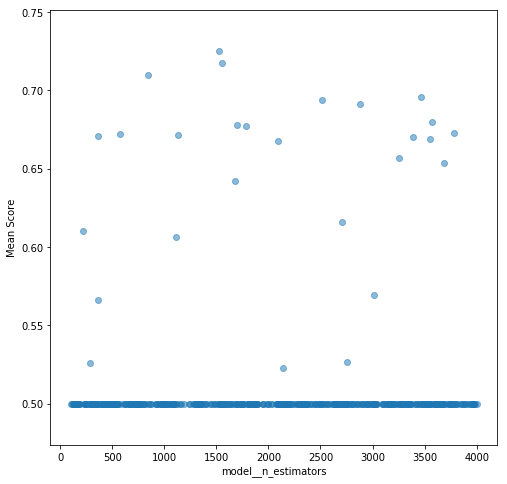

In [55]:
mean_score_scatter('model__n_estimators')

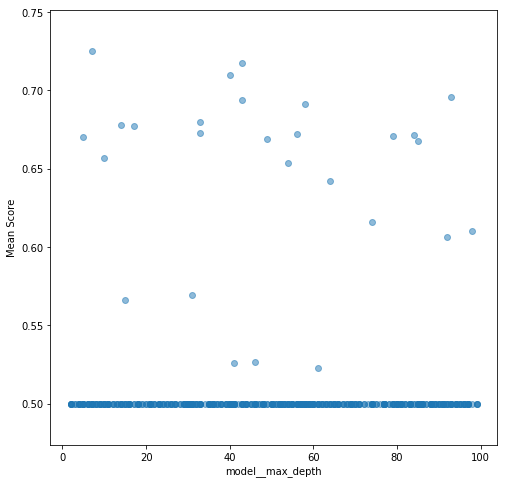

In [57]:
mean_score_scatter('model__max_depth')

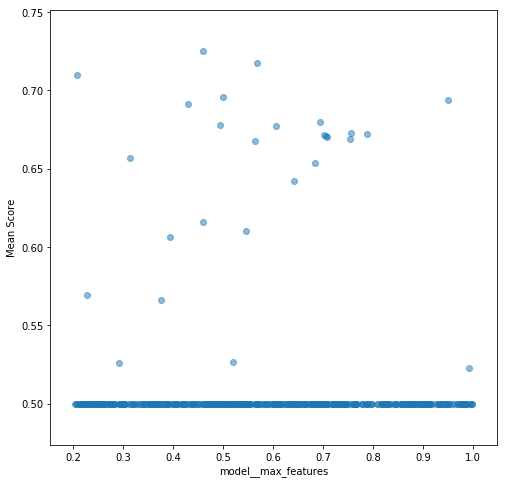

In [58]:
mean_score_scatter('model__max_features')

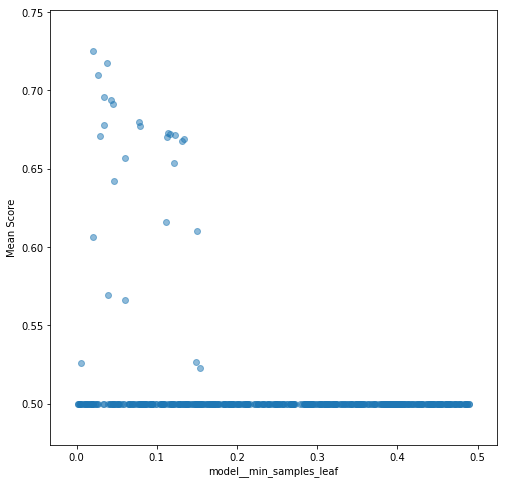

In [59]:
mean_score_scatter('model__min_samples_leaf')

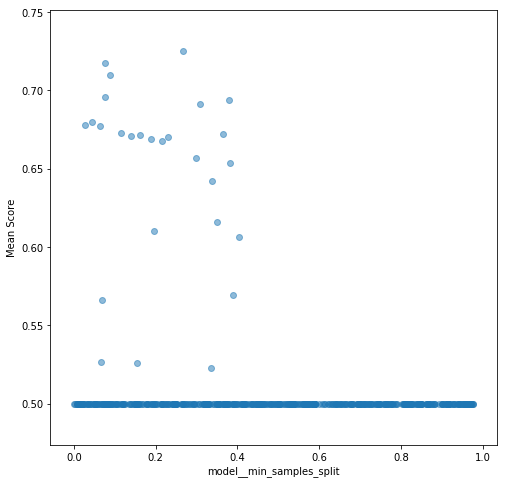

In [60]:
mean_score_scatter('model__min_samples_split')

In [ ]:
# rescale the results so that we get more of a range in colors and sizes
rescaled_means = MinMaxScaler(feature_range=(100, 1000)).fit_transform(results_df['mean_score'].values.reshape(-1, 1))
rescaled_means = rescaled_means.flatten()  # reshape back to array

In [ ]:
def compare_two_parameters(x_label, y_label):
    x = results_df[x_label]
    y = results_df[y_label]
    plt.scatter(x,y,c=rescaled_means, s=rescaled_means, alpha=0.5)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    index_of_best = np.argmax(rescaled_means)
    plt.scatter(x[index_of_best], y[index_of_best], marker= 'x', s=200, color='red')
    fig = plt.gcf()
    fig.set_size_inches(15, 15)

In [ ]:
x_label = 'model__base_estimator__max_depth'
y_label = 'model__base_estimator__min_samples_split'
compare_two_parameters(x_label, y_label)

In [ ]:
grid_search.best_score_, grid_search.best_params_

In [ ]:
x_label = 'model__base_estimator__max_depth'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [ ]:
grid_search.best_score_, grid_search.best_params_

In [ ]:
x_label = 'model__base_estimator__min_samples_split'
y_label = 'model__n_estimators'
compare_two_parameters(x_label, y_label)

In [ ]:
grid_search.best_score_, grid_search.best_params_

reference:

```
N = 1000
r = range(0, N)
x = r
y = r
colors = r
area = r

plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.show()
```

In [ ]:
# column order is based off of the pipeline and FeatureUnion
    # cap_gain_loss_pipeline
    # num_pipeline
    # cat_pipeline
features = ['capital-gain', 'capital-loss'] + ['Net Capital'] + ['age', 'education-num', 'hours-per-week'] + ['GDP Per Capita'] + one_hot_transformer.encoded_columns
importances = grid_search.best_estimator_.steps[1][1].feature_importances_

In [ ]:
import pandas as pd
pd.DataFrame({'feature': features, 'importance': importances}).sort_values(by=['importance'], ascending=False).head(20)